# Documentation

## Notebook History

**Date | Version | Author | Comments**
- 2022-01-19 | 0.3 | Andre Buser | Completed the advanced/correlation anaylsis section. 
- 2022-01-15 | 0.1 | Andre Buser | Initial draft.

## Open tasks / Last Activitites

Open tasks and/or the latest activities in this section:
- [X] #TODO: **Complete** Data Science Ethics Checklist

## Purpose

The objective of this **stage three** notebook is to explore the correlation between the attributes/features.

## Data Science Ethics Checklist

[![Deon badge](https://img.shields.io/badge/ethics%20checklist-deon-brightgreen.svg?style=popout-square)](http://deon.drivendata.org/)

### C. Analysis
 - [**NA**] **C.1 Missing perspectives**: Have we sought to address blindspots in the analysis through engagement with relevant stakeholders (e.g., checking assumptions and discussing implications with affected communities and subject matter experts)?
 - [**NA**] **C.2 Dataset bias**: Have we examined the data for possible sources of bias and taken steps to mitigate or address these biases (e.g., stereotype perpetuation, confirmation bias, imbalanced classes, or omitted confounding variables)?
 - [**NA**] **C.3 Honest representation**: Are our visualizations, summary statistics, and reports designed to honestly represent the underlying data?
 - [**NA**] **C.4 Privacy in analysis**: Have we ensured that data with PII are not used or displayed unless necessary for the analysis?
 - [**NA**] **C.5 Auditability**: Is the process of generating the analysis well documented and reproducible if we discover issues in the future?

*Data Science Ethics Checklist generated with [deon](http://deon.drivendata.org).*


# Setup Environment

## Install Modules

In [1]:
# Document module versions
!pip install watermark

# To generate an advanced the correlation matrix / not used for the moment
# !pip install dython

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.10.0
    Uninstalling importlib-metadata-4.10.0:
      Successfully uninstalled importlib-metadata-4.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


## Import Modules

In [2]:
# Base libraries
import os
import sqlite3

# Scientific libraries
import numpy as np
import pandas as pd
import scipy.stats as stats


# Visual libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Helper libraries
import gc # garbage collection to optimize memory usage, use gc.collect()
import warnings
warnings.filterwarnings('ignore')

# Visual setup
import altair as alt
import matplotlib.ticker as ticker
plt.style.use('fivethirtyeight')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
#custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
#sns.set_palette(custom_colors)
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

# Pandas options
pd.set_option('display.float_format',  '{:,}'.format)
pd.set_option('max_colwidth', 40)
pd.options.display.max_columns = None  # Possible to limit
pd.options.display.max_rows = None  # Possible to limit
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Load magic commands
%load_ext watermark


## Define Parameters

In [3]:
# Using a hybrid path model to ensure that the notebook can be used locally or with Google Colab paths
try:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Paths: Google Colabs Setup
    PATH_EXT = "/content/drive/MyDrive/MADS/SIADS591-592/Project/data/external/"
    PATH_RAW = "/content/drive/MyDrive/MADS/SIADS591-592/Project/data/raw/"
    PATH_INT = "/content/drive/MyDrive/MADS/SIADS591-592/Project/data/interim/"
    PATH_PRO = "/content/drive/MyDrive/MADS/SIADS591-592/Project/data/processed/"
    PATH_REP = "/content/drive/MyDrive/MADS/SIADS591-592/Project/reports/"
    PATH_FIGS = "/content/drive/MyDrive/MADS/SIADS591-592/Project/reports/figures/"

except:
    # Paths: Local Setup
    PATH_EXT = "../data/external/"
    PATH_RAW = "../data/raw/"
    PATH_INT = "../data/interim/"
    PATH_PRO = "../data/processed/"
    PATH_REP = "../reports/"
    PATH_FIGS = "../reports/figures/"

Mounted at /content/drive


# Load Data

In [4]:
# Loading all tables from the sqlite database file
FILENAME = "project_GDPR-fines.sqlite"
data_path = os.path.join(PATH_PRO, FILENAME)

con = sqlite3.connect(data_path)
df_gdpr = pd.read_sql("select * from GDPR", con)
df_gdp = pd.read_sql("select * from GDP", con)
df_cpi = pd.read_sql("select * from CPI", con)
df_pop = pd.read_sql("select * from POP", con)
con.close()

In [5]:
df_gdpr.shape
df_gdp.shape
df_cpi.shape
df_pop.shape

(978, 16)

(124, 7)

(124, 8)

(124, 7)

In [6]:
# Merging all tables into one dataframe
df = pd.DataFrame()
df_gdp = df_gdp[['mapping_key','gdp','gdp_cat']]
df = df_gdpr.merge(df_gdp, on="mapping_key", how='inner')

df_cpi = df_cpi[['iso3','mapping_key','cpi_score','cpi_score_cat']]
df = df.merge(df_cpi, on="mapping_key", how='inner')

df_pop = df_pop[['mapping_key','population','population_cat']]
df = df.merge(df_pop, on="mapping_key", how='inner')

In [7]:
df.head()
df.shape

,etid,country,fine,controller_processor,article,violation_type,sector,summary,decision_date_imputed,decision_year,fine_cat,fine_cat2,mapping_key,country_label,violation_type_label,sector_label,gdp,gdp_cat,iso3,cpi_score,cpi_score_cat,population,population_cat
0,ETid-986,GREECE,"30,000.0",Info Communication Services,"Art. 13 GDPR, Art. 14 GDPR, Art. 11 ...",Insufficient fulfilment of informati...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"30,000.0",6.0,GREECE-2021,11,4,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000
1,ETid-985,GREECE,"25,000.0",Plus Real Advertisement,"Art. 13 GDPR, Art. 14 GDPR, Art. 11 ...",Insufficient fulfilment of informati...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"25,000.0",6.0,GREECE-2021,11,4,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000
2,ETid-957,GREECE,"30,000.0",One Way Private Company,"Art. 28 (3) c) GDPR, Art. 32 (2), (4...",Insufficient technical and organisat...,"Media, Telecoms and Broadcasting",The Hellenic DPA has imposed a fine ...,No,2021,"30,000.0",6.0,GREECE-2021,11,7,6,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000
3,ETid-919,GREECE,"20,000.0",Καπα Λαμδα Ωμεγα Διαφημιστικη Εμπορι...,"Art. 6 GDPR, Art. 12 (2) GDPR, Art. ...",Insufficient legal basis for data pr...,Industry and Commerce,The Hellenic DPA has fined ΚΑΠΑ ΛΑΜΔ...,No,2021,"20,000.0",5.0,GREECE-2021,11,6,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000
4,ETid-897,GREECE,"5,000.0",Premiummedia Παραγωγη Οπτικο-Ακουστι...,"Art. 21 (3) GDPR, Art. 25 GDPR",Insufficient fulfilment of data subj...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"5,000.0",3.0,GREECE-2021,11,3,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000


(978, 23)

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 978 entries, 0 to 977
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   etid                   978 non-null    object 
 1   country                978 non-null    object 
 2   fine                   952 non-null    float64
 3   controller_processor   978 non-null    object 
 4   article                978 non-null    object 
 5   violation_type         978 non-null    object 
 6   sector                 978 non-null    object 
 7   summary                978 non-null    object 
 8   decision_date_imputed  978 non-null    object 
 9   decision_year          978 non-null    int64  
 10  fine_cat               952 non-null    float64
 11  fine_cat2              952 non-null    float64
 12  mapping_key            978 non-null    object 
 13  country_label          978 non-null    int64  
 14  violation_type_label   978 non-null    int64  
 15  sector

In [9]:
df.describe().round(0)

,fine,decision_year,fine_cat,fine_cat2,country_label,violation_type_label,sector_label,gdp,gdp_cat,cpi_score,cpi_score_cat,population,population_cat
count,952.0,978.0,952.0,952.0,978.0,978.0,978.0,975.0,975.0,975.0,975.0,978.0,978.0
mean,"1,382,942.0","2,020.0","1,382,941.0",4.0,19.0,6.0,5.0,"1,048,908,837,723.0","1,048,687,179,487.0",62.0,61.0,"33,671,637.0","33,680,879.0"
std,"25,363,689.0",1.0,"25,363,689.0",3.0,9.0,2.0,2.0,"883,817,360,653.0","883,926,116,514.0",13.0,13.0,"23,099,693.0","23,102,786.0"
min,0.0,"2,018.0",0.0,0.0,0.0,0.0,0.0,"15,215,714,309.0","20,000,000,000.0",42.0,40.0,"38,128.0",0.0
25%,"3,000.0","2,020.0","3,000.0",2.0,12.0,5.0,3.0,"249,696,854,574.0","250,000,000,000.0",53.0,50.0,"10,099,265.0","10,100,000.0"
50%,"10,000.0","2,020.0","10,000.0",4.0,23.0,6.0,5.0,"1,281,484,640,044.0","1,280,000,000,000.0",60.0,60.0,"46,736,776.0","46,700,000.0"
75%,"50,000.0","2,021.0","50,000.0",7.0,27.0,7.0,7.0,"1,320,033,318,744.0","1,320,000,000,000.0",69.0,70.0,"46,771,375.0","46,800,000.0"
max,"746,000,000.0","2,021.0","746,000,000.0",9.0,30.0,9.0,10.0,"3,975,347,237,443.0","3,980,000,000,000.0",89.0,90.0,"84,189,092.0","84,200,000.0"


# Project Objectives

**Objective**: The purpose of the project is to analyze GDPR fines that have been issued since 2018 and to get: 
Basic insights regarding:
- Which industry sectors have been penalized the most?
- **CHANGE** Highest fined company and sector?
- Which EU countries have the most violations?
- **CHANGE** Which GDPR articles have been quoted the most?
- What are the “average costs” of a violation per sector?


Advanced insights by correlating the GDPR fine dataset with the population by country (POP), gross domestic product (GDP), and corruption perception index (CPI) by country, the project intents to verify the following assumptions:
- A higher GDP could lead to: 
  - More violated cases, because a higher GDP could mean more companies in the country
  - Higher fines, because the maximum fine is linked to the total worldwide annual turnover
- A higher CPI could lead to 
  - Fewer violation cases, because the public sector is maybe influenced by the companies
- A higher population could lead to
  - More reported cases because more data subjects could execute their rights

# Correlation Analysis

## Check correlation on non-aggregated dataset

In [10]:
# Group features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Only se numerical features
df_num = df[numerical_features]

In [11]:
# Correlation check
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_num.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

,fine,decision_year,fine_cat,fine_cat2,country_label,violation_type_label,sector_label,gdp,gdp_cat,cpi_score,cpi_score_cat,population,population_cat
fine,1.00,0.04,1.00,1.00,0.04,0.15,0.05,0.15,0.14,0.28,0.27,0.03,0.04
decision_year,0.04,1.00,0.04,0.03,0.19,0.06,-0.04,0.13,0.14,0.02,0.09,0.16,0.09
fine_cat,1.00,0.04,1.00,1.00,0.04,0.15,0.05,0.15,0.14,0.28,0.27,0.03,0.04
fine_cat2,1.00,0.03,1.00,1.00,0.04,0.16,0.04,0.13,0.13,0.29,0.27,0.01,0.03
country_label,0.04,0.19,0.04,0.04,1.00,0.01,-0.02,0.31,0.31,0.17,0.07,0.29,0.30
violation_type_label,0.15,0.06,0.15,0.16,0.01,1.00,-0.10,0.03,0.03,0.07,0.05,0.00,0.01
sector_label,0.05,-0.04,0.05,0.04,-0.02,-0.10,1.00,-0.02,-0.02,0.00,-0.01,-0.03,-0.02
gdp,0.15,0.13,0.15,0.13,0.31,0.03,-0.02,1.00,1.00,0.17,0.15,0.92,0.91
gdp_cat,0.14,0.14,0.14,0.13,0.31,0.03,-0.02,1.00,1.00,0.17,0.15,0.92,0.91
cpi_score,0.28,0.02,0.28,0.29,0.17,0.07,0.00,0.17,0.17,1.00,0.96,-0.10,-0.07


In [12]:
df_num.shape
df_num.dropna(inplace=True)
df_num.shape

(978, 13)

(949, 13)

In [13]:
# Calcualtion p-value for the higher correlation coefficients
# The p-value is about the strength of a hypothesis.
# The p-value is a proportion: if your p-value is 0.05, that means that 
# 5% of the time you would see a test statistic at least as extreme as 
# the one you found if the null hypothesis was true.

stats.spearmanr(df_num['fine'], df_num['violation_type_label'])
stats.spearmanr(df_num['fine'], df_num['cpi_score'])
stats.spearmanr(df_num['fine_cat2'], df_num['cpi_score'])

r = stats.spearmanr(df_num['fine_cat2'], df_num['cpi_score_cat'])
print("CorrCoef:",r[0])
print("pvalue:",r[1])

SpearmanrResult(correlation=0.15327616332770205, pvalue=2.099165553461269e-06)

SpearmanrResult(correlation=0.2842620020209822, pvalue=4.250327117220378e-19)

SpearmanrResult(correlation=0.2937760274633299, pvalue=2.401339040722812e-20)

CorrCoef: 0.274546409139027
pvalue: 7.147520685931605e-18


### **Conclusion**

- **No significant correlations** were identified for the non-aggregated values: fine, population, cpi, gdp.
- Further correlation checks should be done on an aggregated level for fine, population, cpi, gdp


## Answer Basic Questions

### Prepare Dataframe

In [14]:
df_eda = df.copy()

In [15]:
#df_eda.head()
#df_eda.info()
df_eda.shape

(978, 23)

### Which industry sectors have been penalized the most?

In [16]:
# Most penalized by count of GDPR cases:
print("Top 5 penalized sectors by count of GDPR cases")
#df_eda['sector'].value_counts().head(5).to_frame("count")
df_eda.groupby(['sector'])['etid'].count().sort_values(ascending=False).head(5).to_frame("count").reset_index()

Top 5 penalized sectors by count of GDPR cases


,sector,count
0,Industry and Commerce,212
1,"Media, Telecoms and Broadcasting",164
2,Public Sector and Education,131
3,"Finance, Insurance and Consulting",98
4,Health Care,80


In [17]:
# Most penalized by sum of GDPR fines:
print("Top 5 penalized sectors by sum of GDPR fines")
#df_eda['sector'].value_counts().head(5).to_frame("count")
df_eda.groupby(['sector'])['fine'].sum().sort_values(ascending=False).head(5).to_frame("count").reset_index()

Top 5 penalized sectors by sum of GDPR fines


,sector,count
0,Industry and Commerce,"767,539,792.0"
1,"Media, Telecoms and Broadcasting","370,180,441.0"
2,Transportation and Energy,"53,341,369.0"
3,Employment,"47,711,677.0"
4,"Finance, Insurance and Consulting","28,536,065.0"


In [18]:
# Overview of sector
df_eda.groupby(['sector'])['fine'].agg(['sum','mean','size']).round(0).reset_index()#.sort_values(ascending=False).head(5).to_frame("sum")

,sector,sum,mean,size
0,Accomodation and Hospitalty,"21,461,207.0","766,472.0",28
1,Employment,"47,711,677.0","701,642.0",69
2,"Finance, Insurance and Consulting","28,536,065.0","303,575.0",98
3,Health Care,"12,510,933.0","158,366.0",80
4,Individuals and Private Associations,"1,367,646.0","19,821.0",71
5,Industry and Commerce,"767,539,792.0","3,762,450.0",212
6,"Media, Telecoms and Broadcasting","370,180,441.0","2,285,064.0",164
7,Public Sector and Education,"12,650,713.0","99,612.0",131
8,Real Estate,"515,970.0","19,845.0",27
9,Transportation and Energy,"53,341,369.0","1,212,304.0",44


### Highest fined company and sector?

In [19]:
# Most penalized by sum of GDPR fines:
print("Top 5 highest fined companies")
df_eda.groupby(['controller_processor'])['fine'].max().sort_values(ascending=False).head(5).to_frame("max").reset_index()

Top 5 highest fined companies


,controller_processor,max
0,Amazon Europe Core S.À.R.L.,"746,000,000.0"
1,Whatsapp Ireland Ltd.,"225,000,000.0"
2,Google Llc,"50,000,000.0"
3,H&M Hennes & Mauritz Online Shop A.B...,"35,258,708.0"
4,Tim (Telecommunications Operator),"27,800,000.0"


In [20]:
# Most penalized by sum of GDPR fines:
print("Top 5 highest fined sectors")
df_eda.groupby(['sector'])['fine'].max().sort_values(ascending=False).head(5).to_frame("max").reset_index()

Top 5 highest fined sectors


,sector,max
0,Industry and Commerce,"746,000,000.0"
1,"Media, Telecoms and Broadcasting","225,000,000.0"
2,Employment,"35,258,708.0"
3,Transportation and Energy,"22,046,000.0"
4,Accomodation and Hospitalty,"20,450,000.0"


### Which EU countries have the most violations?

In [21]:
# Most penalized by GDPR cases opened:
print("Top 5 penalized countries by count of GDPR cases")
#df_eda['sector'].value_counts().head(5).to_frame("count")
df_eda.groupby(['country','iso3'])['fine'].count().sort_values(ascending=False).head(5).to_frame("count").reset_index()

Top 5 penalized countries by count of GDPR cases


,country,iso3,count
0,SPAIN,ESP,352
1,ITALY,ITA,103
2,ROMANIA,ROU,69
3,HUNGARY,HUN,45
4,NORWAY,NOR,36


In [22]:
# Most penalized countries by sum of GDPR fines:
print("Top 5 penalized countries by sum of GDPR fines")
df_eda.groupby(['country','iso3'])['fine'].sum().sort_values(ascending=False).head(5).to_frame("sum").reset_index()

Top 5 penalized countries by sum of GDPR fines


,country,iso3,sum
0,LUXEMBOURG,LUX,"746,257,900.0"
1,IRELAND,IRL,"225,877,900.0"
2,ITALY,ITA,"89,804,096.0"
3,FRANCE,FRA,"58,194,300.0"
4,GERMANY,DEU,"50,159,583.0"


In [23]:
df_eda[df_eda['country'] == "LUXEMBOURG"].groupby('decision_year')['fine'].count()

decision_year
2021    16
Name: fine, dtype: int64

In [24]:
df_eda[df_eda['country'] == "FRANCE"].groupby('decision_year')['fine'].count()

decision_year
2019     5
2020     6
2021    10
Name: fine, dtype: int64

### Which violation types have been raised the most?

In [25]:
df_eda.groupby(['violation_type'])['violation_type'].count().sort_values(ascending=False).head(5).to_frame("count").reset_index()

,violation_type,count
0,Insufficient legal basis for data pr...,337
1,Non-compliance with general data pro...,197
2,Insufficient technical and organisat...,193
3,Insufficient fulfilment of data subj...,90
4,Insufficient fulfilment of informati...,82


In [26]:
#df.groupby(['violation_type','gdpr_article_short'])['violation_type'].count().sort_values(ascending=False).head(5).to_frame("count")

### What are the “average costs” of a violation per sector?

In [27]:
df_eda.groupby(['sector'])['fine'].mean().sort_values(ascending=False).head(5).to_frame("avg.").reset_index().round(0)

,sector,avg.
0,Industry and Commerce,"3,762,450.0"
1,"Media, Telecoms and Broadcasting","2,285,064.0"
2,Transportation and Energy,"1,212,304.0"
3,Accomodation and Hospitalty,"766,472.0"
4,Employment,"701,642.0"


### Which GDPR articles have been quoted the most?

In [28]:
df.head()

,etid,country,fine,controller_processor,article,violation_type,sector,summary,decision_date_imputed,decision_year,fine_cat,fine_cat2,mapping_key,country_label,violation_type_label,sector_label,gdp,gdp_cat,iso3,cpi_score,cpi_score_cat,population,population_cat
0,ETid-986,GREECE,"30,000.0",Info Communication Services,"Art. 13 GDPR, Art. 14 GDPR, Art. 11 ...",Insufficient fulfilment of informati...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"30,000.0",6.0,GREECE-2021,11,4,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000
1,ETid-985,GREECE,"25,000.0",Plus Real Advertisement,"Art. 13 GDPR, Art. 14 GDPR, Art. 11 ...",Insufficient fulfilment of informati...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"25,000.0",6.0,GREECE-2021,11,4,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000
2,ETid-957,GREECE,"30,000.0",One Way Private Company,"Art. 28 (3) c) GDPR, Art. 32 (2), (4...",Insufficient technical and organisat...,"Media, Telecoms and Broadcasting",The Hellenic DPA has imposed a fine ...,No,2021,"30,000.0",6.0,GREECE-2021,11,7,6,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000
3,ETid-919,GREECE,"20,000.0",Καπα Λαμδα Ωμεγα Διαφημιστικη Εμπορι...,"Art. 6 GDPR, Art. 12 (2) GDPR, Art. ...",Insufficient legal basis for data pr...,Industry and Commerce,The Hellenic DPA has fined ΚΑΠΑ ΛΑΜΔ...,No,2021,"20,000.0",5.0,GREECE-2021,11,6,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000
4,ETid-897,GREECE,"5,000.0",Premiummedia Παραγωγη Οπτικο-Ακουστι...,"Art. 21 (3) GDPR, Art. 25 GDPR",Insufficient fulfilment of data subj...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"5,000.0",3.0,GREECE-2021,11,3,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000


In [29]:
df_split = df.copy()
# Replacing , Art to get a better split option (quick and dirty)
df_split['article'].replace(", Art.", ", Art. Art.", regex=True, inplace=True)

# Split articles
separator = ', Art.'
df_split['article'] = df_split['article'].str.split(separator)
df_split = df_split.explode('article')

# Extract GDPR article into separate column
pattern = r'(Art.\s\d+)'
df_split['gdpr_article_short'] = df_split['article'].str.extract(pattern)

# Replace dummy Art. 00 with Unknown
df_split['gdpr_article_short'].replace("Art. 00", "Art. Unknown",inplace=True)
df_split['gdpr_article_short'].unique()

# Create temp column to identify GDPR relevant articles
df_split['gdpr_article'] = df_split["article"].str.contains('GDPR')
df_split.shape

# Remove all non-GDPR articles
df_split = df_split[df_split['gdpr_article'] == True]

array(['Art. 13', 'Art. 14', 'Art. 11', 'Art. 28', 'Art. 32', 'Art. 6',
       'Art. 12', 'Art. 21', 'Art. 25', 'Art. 5', 'Art. 17', 'Art. 15',
       'Art. 24', 'Art. 33', 'Art. 34', 'Art. 31', 'Art. 58', 'Art. 29',
       'Art. 3', 'Art. 7', 'Art. 9', 'Art. 2', 'Art. 35', 'Art. 44',
       'Art. 46', 'Art. 30', 'Art. 22', 'Art. 37', 'Art. Unknown',
       'Art. 48', 'Art. 23', 'Art. 16', 'Art. 82', nan, 'Art. 8',
       'Art. 38', 'Art. 39', 'Art. 27', 'Art. 18', 'Art. 19', 'Art. 20',
       'Art. 36'], dtype=object)

(1981, 25)

In [30]:
df_split['gdpr_article_short'].value_counts().to_frame("count").head(5)

,count
Art. 5,511
Art. 6,387
Art. 32,230
Art. 13,157
Art. 12,77


#### Label Encoding

In [31]:
# Add labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_split['gdpr_article_short_label']= le.fit_transform(df_split['gdpr_article_short'].values)

In [32]:
df_split.head().round(0)
df_split.shape

,etid,country,fine,controller_processor,article,violation_type,sector,summary,decision_date_imputed,decision_year,fine_cat,fine_cat2,mapping_key,country_label,violation_type_label,sector_label,gdp,gdp_cat,iso3,cpi_score,cpi_score_cat,population,population_cat,gdpr_article_short,gdpr_article,gdpr_article_short_label
0,ETid-986,GREECE,"30,000.0",Info Communication Services,Art. 13 GDPR,Insufficient fulfilment of informati...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"30,000.0",6.0,GREECE-2021,11,4,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000,Art. 13,True,1
0,ETid-986,GREECE,"30,000.0",Info Communication Services,Art. 14 GDPR,Insufficient fulfilment of informati...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"30,000.0",6.0,GREECE-2021,11,4,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000,Art. 14,True,2
1,ETid-985,GREECE,"25,000.0",Plus Real Advertisement,Art. 13 GDPR,Insufficient fulfilment of informati...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"25,000.0",6.0,GREECE-2021,11,4,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000,Art. 13,True,1
1,ETid-985,GREECE,"25,000.0",Plus Real Advertisement,Art. 14 GDPR,Insufficient fulfilment of informati...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"25,000.0",6.0,GREECE-2021,11,4,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000,Art. 14,True,2
2,ETid-957,GREECE,"30,000.0",One Way Private Company,Art. 28 (3) c) GDPR,Insufficient technical and organisat...,"Media, Telecoms and Broadcasting",The Hellenic DPA has imposed a fine ...,No,2021,"30,000.0",6.0,GREECE-2021,11,7,6,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000,Art. 28,True,14


(1938, 26)

#### Check Correlation 

In [33]:
df_split.corr()

,fine,decision_year,fine_cat,fine_cat2,country_label,violation_type_label,sector_label,gdp,gdp_cat,cpi_score,cpi_score_cat,population,population_cat,gdpr_article,gdpr_article_short_label
fine,1.0,0.0330863615992328,0.9999999999998719,0.10546374091518766,-0.012974661564438246,0.003927731553400072,0.014185694765785918,-0.005642119655656886,-0.005623020569080438,0.05340189519741708,0.04771035735410796,-0.024482863769186014,-0.02452122962200598,nan,-0.00754937489539802
decision_year,0.0330863615992328,1.0,0.03308636422125236,0.10890422432222947,0.17866407105979243,0.09191189786398084,0.019070159923451537,0.04341693841323071,0.04308787103230455,0.062112890281412286,0.0977479146682278,0.08348598406590874,0.08339650904280942,nan,-0.043120366091451645
fine_cat,0.9999999999998719,0.03308636422125236,1.0,0.10546374321613101,-0.012974667381932538,0.003927760833875183,0.014185698385586122,-0.0056421234883761206,-0.005623024334838103,0.05340187555938349,0.04771033729162318,-0.024482862411142628,-0.024521228242700678,nan,-0.007549365111903685
fine_cat2,0.10546374091518766,0.10890422432222947,0.10546374321613101,1.0,0.01730319469494911,0.17105498134030164,0.030034325749308668,0.21737441328077425,0.21726950868738604,0.2532794200421101,0.26106917094021576,0.13620273534302021,0.13609660042499577,nan,0.03736407023290769
country_label,-0.012974661564438246,0.17866407105979243,-0.012974667381932538,0.01730319469494911,1.0,0.001624226353109539,-0.028904584765533033,0.09506692025818254,0.09439699144427803,0.0028971714714265185,-0.05877379533914814,0.255773822883918,0.25607093300283945,nan,0.11055647263430922
violation_type_label,0.003927731553400072,0.09191189786398084,0.003927760833875183,0.17105498134030164,0.001624226353109539,1.0,-0.09040033075088265,0.0673156582785371,0.06708839298737156,0.023492781339621443,0.022168155923455894,0.04228416722223808,0.04224189209546746,nan,0.2443407380905787
sector_label,0.014185694765785918,0.019070159923451537,0.014185698385586122,0.030034325749308668,-0.028904584765533033,-0.09040033075088265,1.0,-0.012126496663306922,-0.011851716200606065,0.006680893951773097,0.015789617680016136,-0.0035980726848532296,-0.0036556893189071474,nan,-0.04260751847714382
gdp,-0.005642119655656886,0.04341693841323071,-0.0056421234883761206,0.21737441328077425,0.09506692025818254,0.0673156582785371,-0.012126496663306922,1.0,0.9999944418684342,0.037333610843044394,0.08455489918350594,0.9405141724971243,0.940426123113678,nan,0.03536954905435945
gdp_cat,-0.005623020569080438,0.04308787103230455,-0.005623024334838103,0.21726950868738604,0.09439699144427803,0.06708839298737156,-0.011851716200606065,0.9999944418684342,1.0,0.03752125699798847,0.0846190304018936,0.9404271112388637,0.9403403473088549,nan,0.03501365261225677
cpi_score,0.05340189519741708,0.062112890281412286,0.05340187555938349,0.2532794200421101,0.0028971714714265185,0.023492781339621443,0.006680893951773097,0.037333610843044394,0.03752125699798847,1.0,0.979491073759094,-0.18172059882956437,-0.18164253087148036,nan,0.04947969861498141


In [34]:
df_dummy = df_split[['violation_type','gdpr_article_short']]
df_dummy = pd.get_dummies(df_dummy)
#df_dummy.head()

corr_df = df_dummy.corr(method='spearman')
#corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)
#corr_df.iloc[10:, 0:10].style.background_gradient(cmap='coolwarm').set_precision(2)

corr_filtered = corr_df.iloc[10:, 0:10]
corr_filtered[corr_filtered > 0.54].dropna(how='all').style.background_gradient(cmap='coolwarm').set_precision(2)

,violation_type_Insufficient cooperation with supervisory authority,violation_type_Insufficient data processing agreement,violation_type_Insufficient fulfilment of data breach notification obligations,violation_type_Insufficient fulfilment of data subjects rights,violation_type_Insufficient fulfilment of information obligations,violation_type_Insufficient involvement of data protection officer,violation_type_Insufficient legal basis for data processing,violation_type_Insufficient technical and organisational measures to ensure information security,violation_type_Non-compliance with general data processing principles,violation_type_Unknown
gdpr_article_short_Art. 32,nan,nan,nan,nan,nan,nan,nan,0.65,nan,nan
gdpr_article_short_Art. 33,nan,nan,0.55,nan,nan,nan,nan,nan,nan,nan
gdpr_article_short_Art. 58,0.73,nan,nan,nan,nan,nan,nan,nan,nan,nan
gdpr_article_short_Art. Unknown,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.76


In [35]:
corr_filtered = corr_df.iloc[10:, 0:10]
corr_filtered[corr_filtered > 0.2].dropna(how='all',axis=0).dropna(how='all', axis=1).style.background_gradient(cmap='coolwarm').set_precision(2)

,violation_type_Insufficient cooperation with supervisory authority,violation_type_Insufficient data processing agreement,violation_type_Insufficient fulfilment of data breach notification obligations,violation_type_Insufficient fulfilment of data subjects rights,violation_type_Insufficient fulfilment of information obligations,violation_type_Insufficient involvement of data protection officer,violation_type_Insufficient legal basis for data processing,violation_type_Insufficient technical and organisational measures to ensure information security,violation_type_Non-compliance with general data processing principles,violation_type_Unknown
gdpr_article_short_Art. 12,nan,nan,nan,0.21,nan,nan,nan,nan,nan,nan
gdpr_article_short_Art. 13,nan,nan,nan,nan,0.47,nan,nan,nan,nan,nan
gdpr_article_short_Art. 15,nan,nan,nan,0.44,nan,nan,nan,nan,nan,nan
gdpr_article_short_Art. 17,nan,nan,nan,0.25,nan,nan,nan,nan,nan,nan
gdpr_article_short_Art. 21,nan,nan,nan,0.20,nan,nan,nan,nan,nan,nan
gdpr_article_short_Art. 28,nan,0.27,nan,nan,nan,nan,nan,nan,nan,nan
gdpr_article_short_Art. 31,0.47,nan,nan,nan,nan,nan,nan,nan,nan,nan
gdpr_article_short_Art. 32,nan,nan,nan,nan,nan,nan,nan,0.65,nan,nan
gdpr_article_short_Art. 33,nan,nan,0.55,nan,nan,nan,nan,nan,nan,nan
gdpr_article_short_Art. 34,nan,nan,0.41,nan,nan,nan,nan,nan,nan,nan


In [36]:
df_split_grouped = df_split.groupby(['gdpr_article_short','violation_type'])['fine'].count()
df_split_grouped = df_split_grouped.reset_index()
df_split_grouped.head()

,gdpr_article_short,violation_type,fine
0,Art. 12,Insufficient data processing agreement,1
1,Art. 12,Insufficient fulfilment of data subj...,32
2,Art. 12,Insufficient fulfilment of informati...,12
3,Art. 12,Insufficient legal basis for data pr...,16
4,Art. 12,Non-compliance with general data pro...,12


In [37]:
df_split_grouped['fine'] = df_split_grouped['fine'].astype(int)
#plot_df = plot_df[plot_df['count_infection_cases'] > 0]
plot_df = df_split_grouped.pivot("violation_type", "gdpr_article_short", "fine")
#plot_df

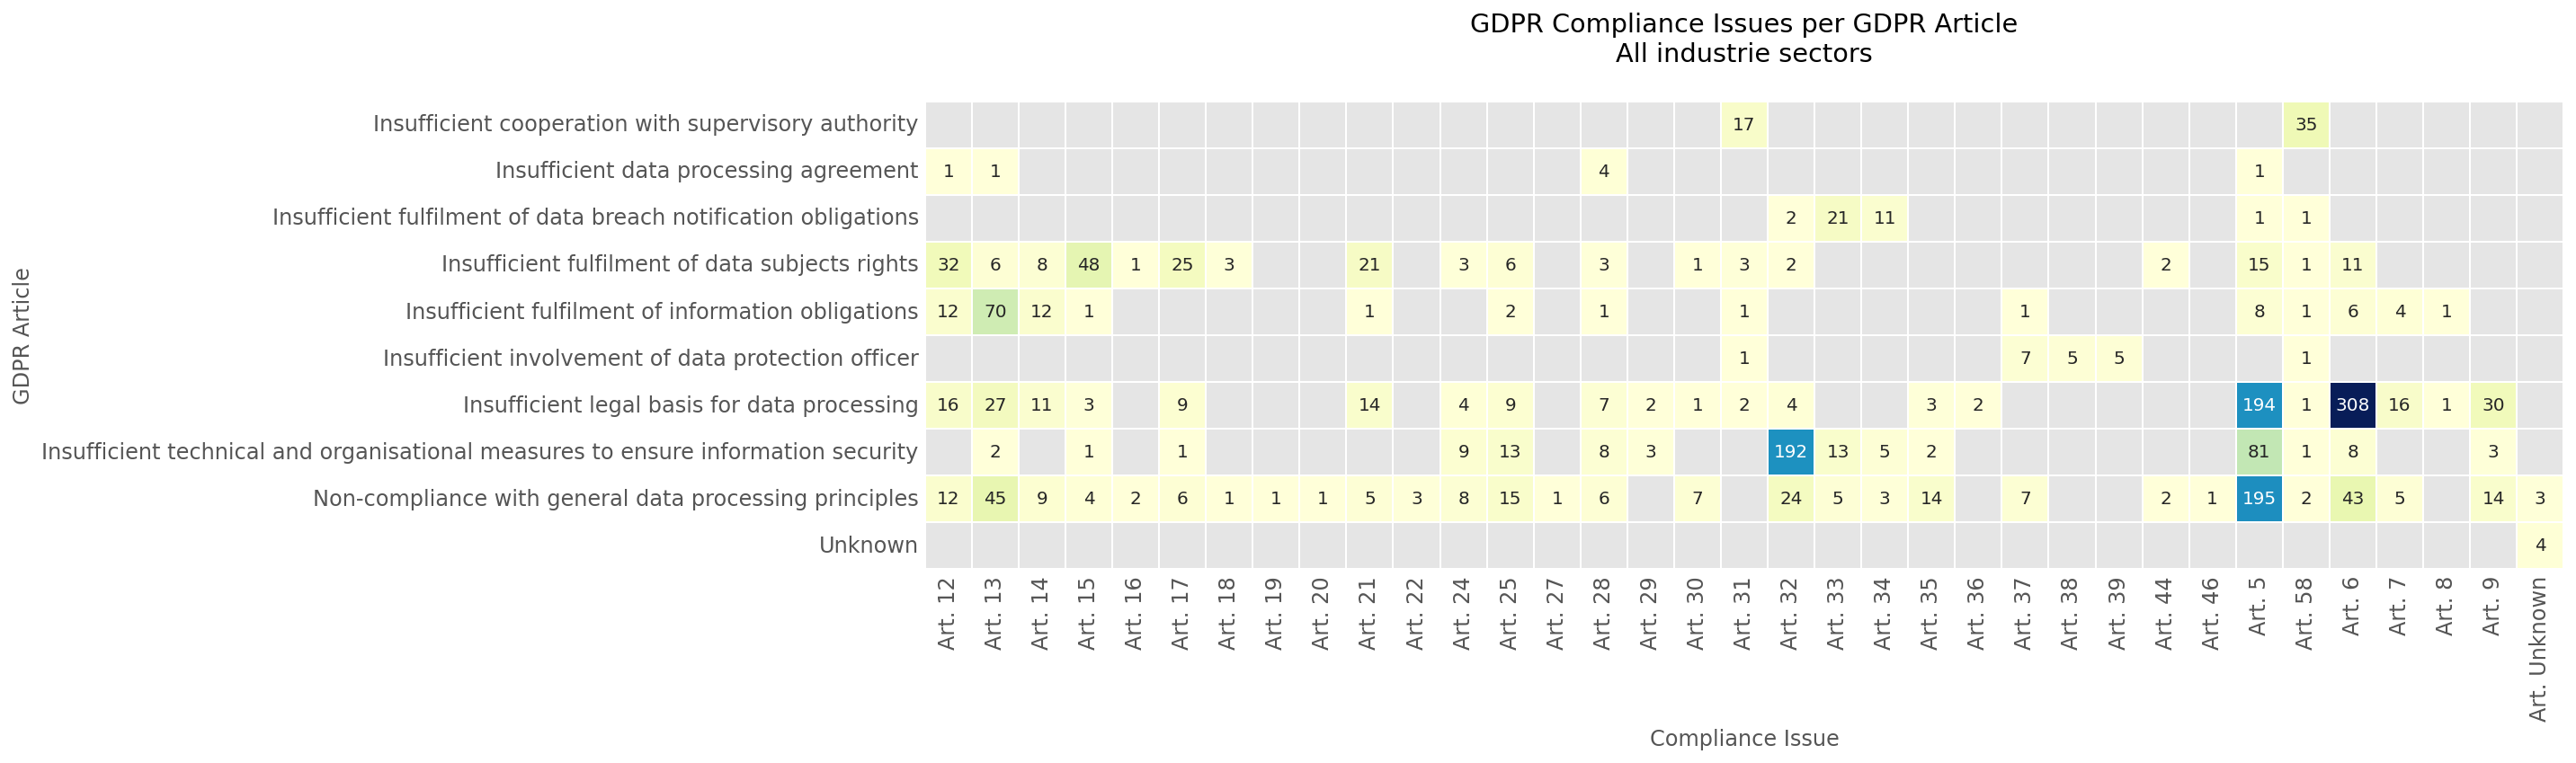

In [38]:
plt.rcParams["figure.figsize"] = [20, 6]
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.style.use('ggplot')

plt.rcParams["figure.autolayout"] = True
ax = sns.heatmap(plot_df, annot=True, linewidths=.5, fmt=".0f", cbar=False, cmap="YlGnBu")
plt.title("GDPR Compliance Issues per GDPR Article\nAll industrie sectors\n")
plt.ylabel("GDPR Article")
plt.xlabel("Compliance Issue")
#plt.xticks(rotation=65)
plt.show();

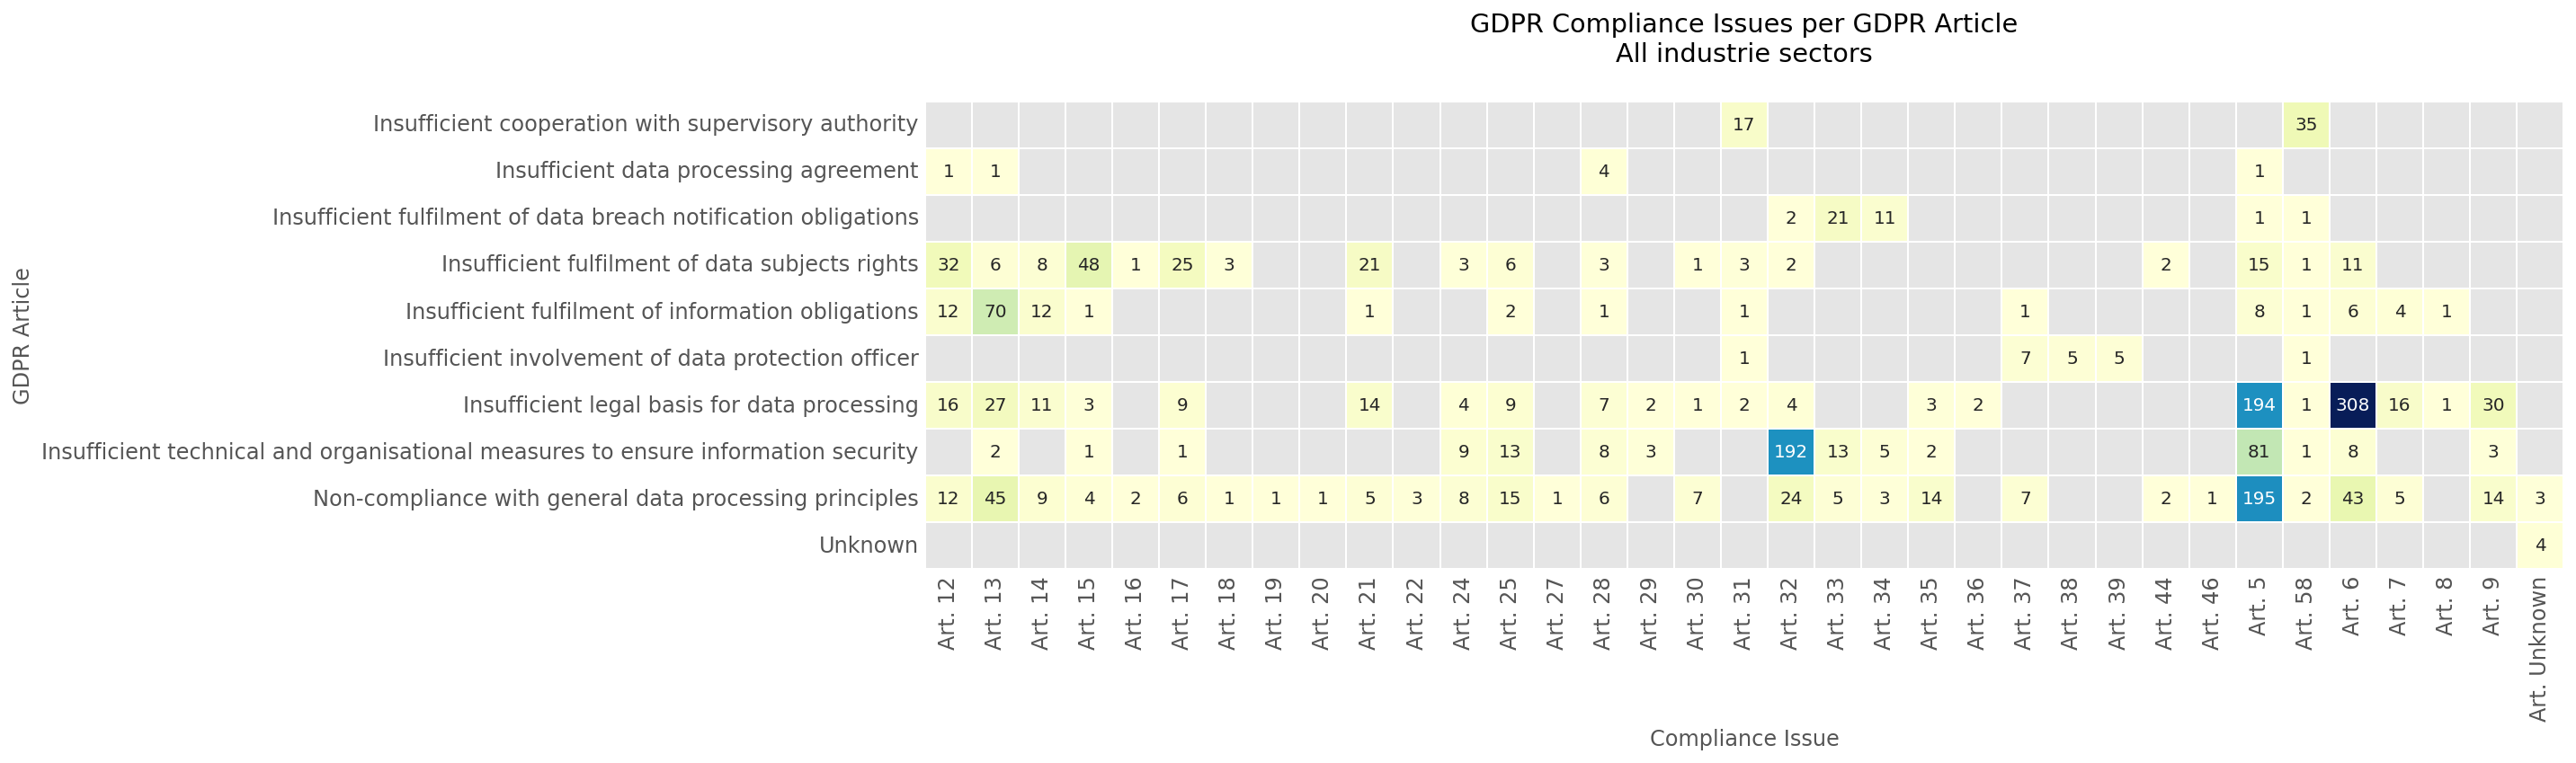

In [39]:
plt.rcParams["figure.figsize"] = [20, 6]
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.style.use('ggplot')

plt.rcParams["figure.autolayout"] = True
ax = sns.heatmap(plot_df, annot=True, linewidths=.5, fmt=".0f", cbar=False, cmap="YlGnBu")
plt.title("GDPR Compliance Issues per GDPR Article\nAll industrie sectors\n")
plt.ylabel("GDPR Article")
plt.xlabel("Compliance Issue")
#plt.xticks(rotation=65)
plt.show();

#### Extra: Check Correlation for Quoted GDPR Articles

In [40]:
# Group features
numerical_features = df_split.select_dtypes(include=[np.number]).columns.tolist()
df_split_num = df_split[numerical_features]

In [41]:
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_split_num.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

,fine,decision_year,fine_cat,fine_cat2,country_label,violation_type_label,sector_label,gdp,gdp_cat,cpi_score,cpi_score_cat,population,population_cat,gdpr_article_short_label
fine,1.00,0.10,1.00,0.99,0.03,0.16,0.05,0.26,0.26,0.24,0.24,0.14,0.14,-0.00
decision_year,0.10,1.00,0.10,0.10,0.14,0.11,0.01,0.14,0.14,0.05,0.10,0.08,0.05,-0.05
fine_cat,1.00,0.10,1.00,0.99,0.03,0.16,0.05,0.26,0.26,0.24,0.24,0.14,0.14,-0.00
fine_cat2,0.99,0.10,0.99,1.00,0.03,0.16,0.05,0.25,0.25,0.26,0.25,0.12,0.12,-0.00
country_label,0.03,0.14,0.03,0.03,1.00,0.01,-0.03,0.23,0.23,0.15,0.07,0.20,0.20,0.09
violation_type_label,0.16,0.11,0.16,0.16,0.01,1.00,-0.05,0.06,0.06,-0.00,-0.02,0.04,0.04,0.10
sector_label,0.05,0.01,0.05,0.05,-0.03,-0.05,1.00,0.02,0.02,0.01,0.01,0.01,0.01,-0.03
gdp,0.26,0.14,0.26,0.25,0.23,0.06,0.02,1.00,1.00,0.11,0.11,0.92,0.91,0.05
gdp_cat,0.26,0.14,0.26,0.25,0.23,0.06,0.02,1.00,1.00,0.11,0.11,0.92,0.92,0.05
cpi_score,0.24,0.05,0.24,0.26,0.15,-0.00,0.01,0.11,0.11,1.00,0.97,-0.16,-0.15,0.03


## Answer Hypothesis (Advanced Questions)

### **A higher GDP could lead to more reported cases**
because a higher GDP could mean more companies in the country

#### Prepare DataFrame

In [42]:
df.head()

,etid,country,fine,controller_processor,article,violation_type,sector,summary,decision_date_imputed,decision_year,fine_cat,fine_cat2,mapping_key,country_label,violation_type_label,sector_label,gdp,gdp_cat,iso3,cpi_score,cpi_score_cat,population,population_cat
0,ETid-986,GREECE,"30,000.0",Info Communication Services,"Art. 13 GDPR, Art. 14 GDPR, Art. 11 ...",Insufficient fulfilment of informati...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"30,000.0",6.0,GREECE-2021,11,4,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000
1,ETid-985,GREECE,"25,000.0",Plus Real Advertisement,"Art. 13 GDPR, Art. 14 GDPR, Art. 11 ...",Insufficient fulfilment of informati...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"25,000.0",6.0,GREECE-2021,11,4,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000
2,ETid-957,GREECE,"30,000.0",One Way Private Company,"Art. 28 (3) c) GDPR, Art. 32 (2), (4...",Insufficient technical and organisat...,"Media, Telecoms and Broadcasting",The Hellenic DPA has imposed a fine ...,No,2021,"30,000.0",6.0,GREECE-2021,11,7,6,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000
3,ETid-919,GREECE,"20,000.0",Καπα Λαμδα Ωμεγα Διαφημιστικη Εμπορι...,"Art. 6 GDPR, Art. 12 (2) GDPR, Art. ...",Insufficient legal basis for data pr...,Industry and Commerce,The Hellenic DPA has fined ΚΑΠΑ ΛΑΜΔ...,No,2021,"20,000.0",5.0,GREECE-2021,11,6,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000
4,ETid-897,GREECE,"5,000.0",Premiummedia Παραγωγη Οπτικο-Ακουστι...,"Art. 21 (3) GDPR, Art. 25 GDPR",Insufficient fulfilment of data subj...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"5,000.0",3.0,GREECE-2021,11,3,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000


In [43]:
#df_ada_grouped = df.groupby(['country'])['fine','gdp','cpi_score','population'].agg({'fine':['median','mean'],'gdp':'mean','cpi_score':'mean','population':'mean'}).reset_index()
df_ada_grouped = df.groupby(['decision_year','country'])['fine','gdp','cpi_score','population','gdp_cat','cpi_score_cat','population_cat'].agg(['median','mean']).reset_index()
df_ada_grouped.head()

decision_year         country     fine                          gdp  \
                                  median     mean              median   
0          2018         AUSTRIA  2,000.0  2,275.0   454,872,626,780.0   
1          2018        BULGARIA    500.0    500.0    66,230,155,100.0   
2          2018  CZECH REPUBLIC    388.0    388.0   248,950,103,352.0   
3          2018         GERMANY 12,500.0 11,279.5 3,975,347,237,443.0   
4          2018         HUNGARY  3,200.0  3,200.0   160,431,092,909.0   

                      cpi_score      population                       gdp_cat  \
                 mean    median mean     median      mean              median   
0   454,872,626,780.0      76.0 76.0    8891388   8891388   450,000,000,000.0   
1    66,230,155,100.0      42.0 42.0    7051608   7051608    70,000,000,000.0   
2   248,950,103,352.0      59.0 59.0   10665677  10665677   250,000,000,000.0   
3 3,975,347,237,443.0      80.0 80.0   83124418  83124418 3,980,000,000,000.0   
4   160,431,092,909.0      46.0 46.0    9707499   9707499   160,000,000,000.0   

                      cpi_score_cat      population_cat            
                 mean        median mean         median      mean  
0   450,000,000,000.0          80.0 80.0        8900000   8900000  
1    70,000,000,000.0          40.0 40.0        7100000   7100000  
2   250,000,000,000.0          60.0 60.0       10700000  10700000  
3 3,980,000,000,000.0          80.0 80.0       83100000  83100000  
4   160,000,000,000.0          50.0 50.0        9700000   9700000

In [44]:
# flatten grouped dataframe
df_ada_grouped_flatten = df_ada_grouped.copy()
df_ada_grouped_flatten.columns = ['_'.join(i).rstrip('_') for i in df_ada_grouped_flatten.columns.values]
#df_ada_grouped_flatten

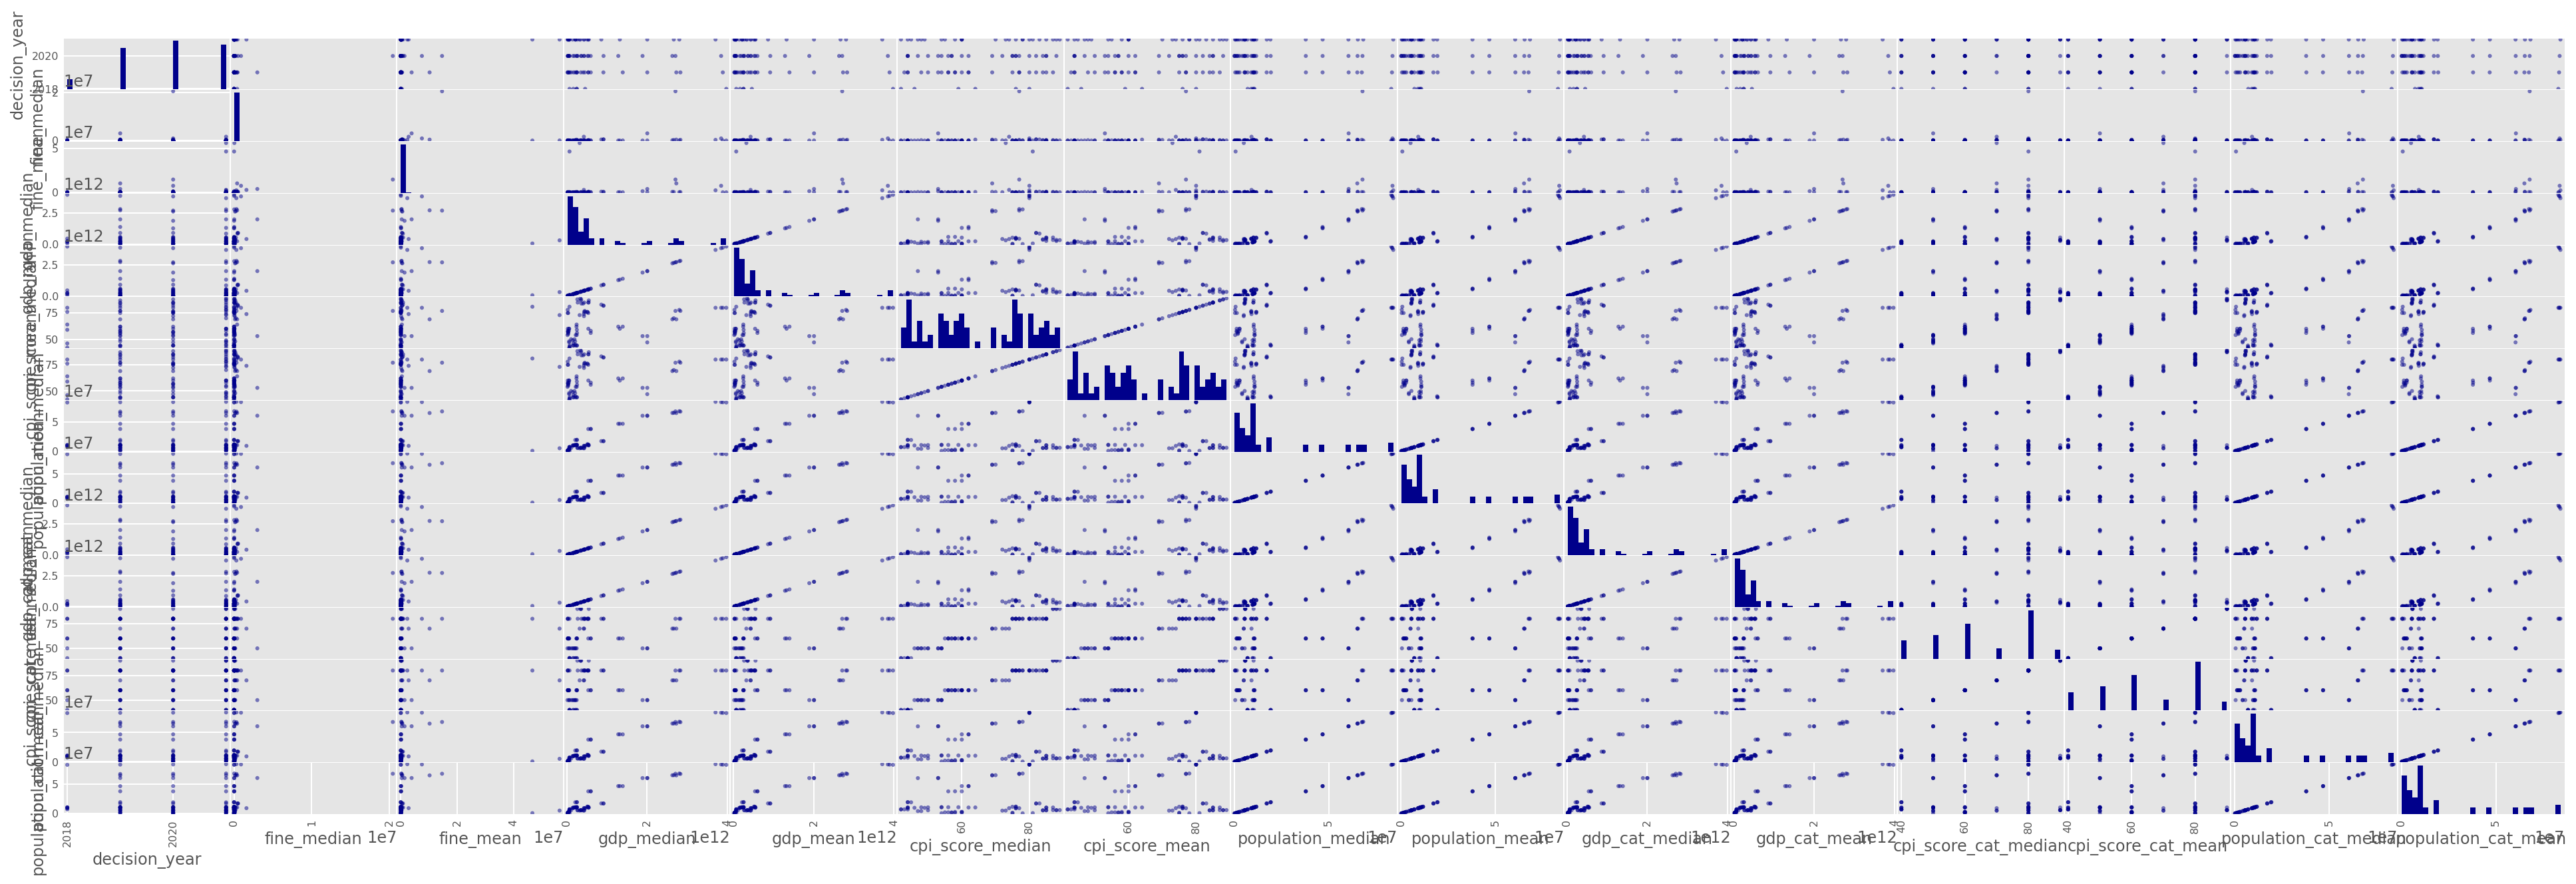

In [45]:
pd.plotting.scatter_matrix(df_ada_grouped_flatten, figsize=(30,10),color='darkblue', hist_kwds={'bins':30, 'color':'darkblue'} );

#### Check Distribution - "Outliers" Included

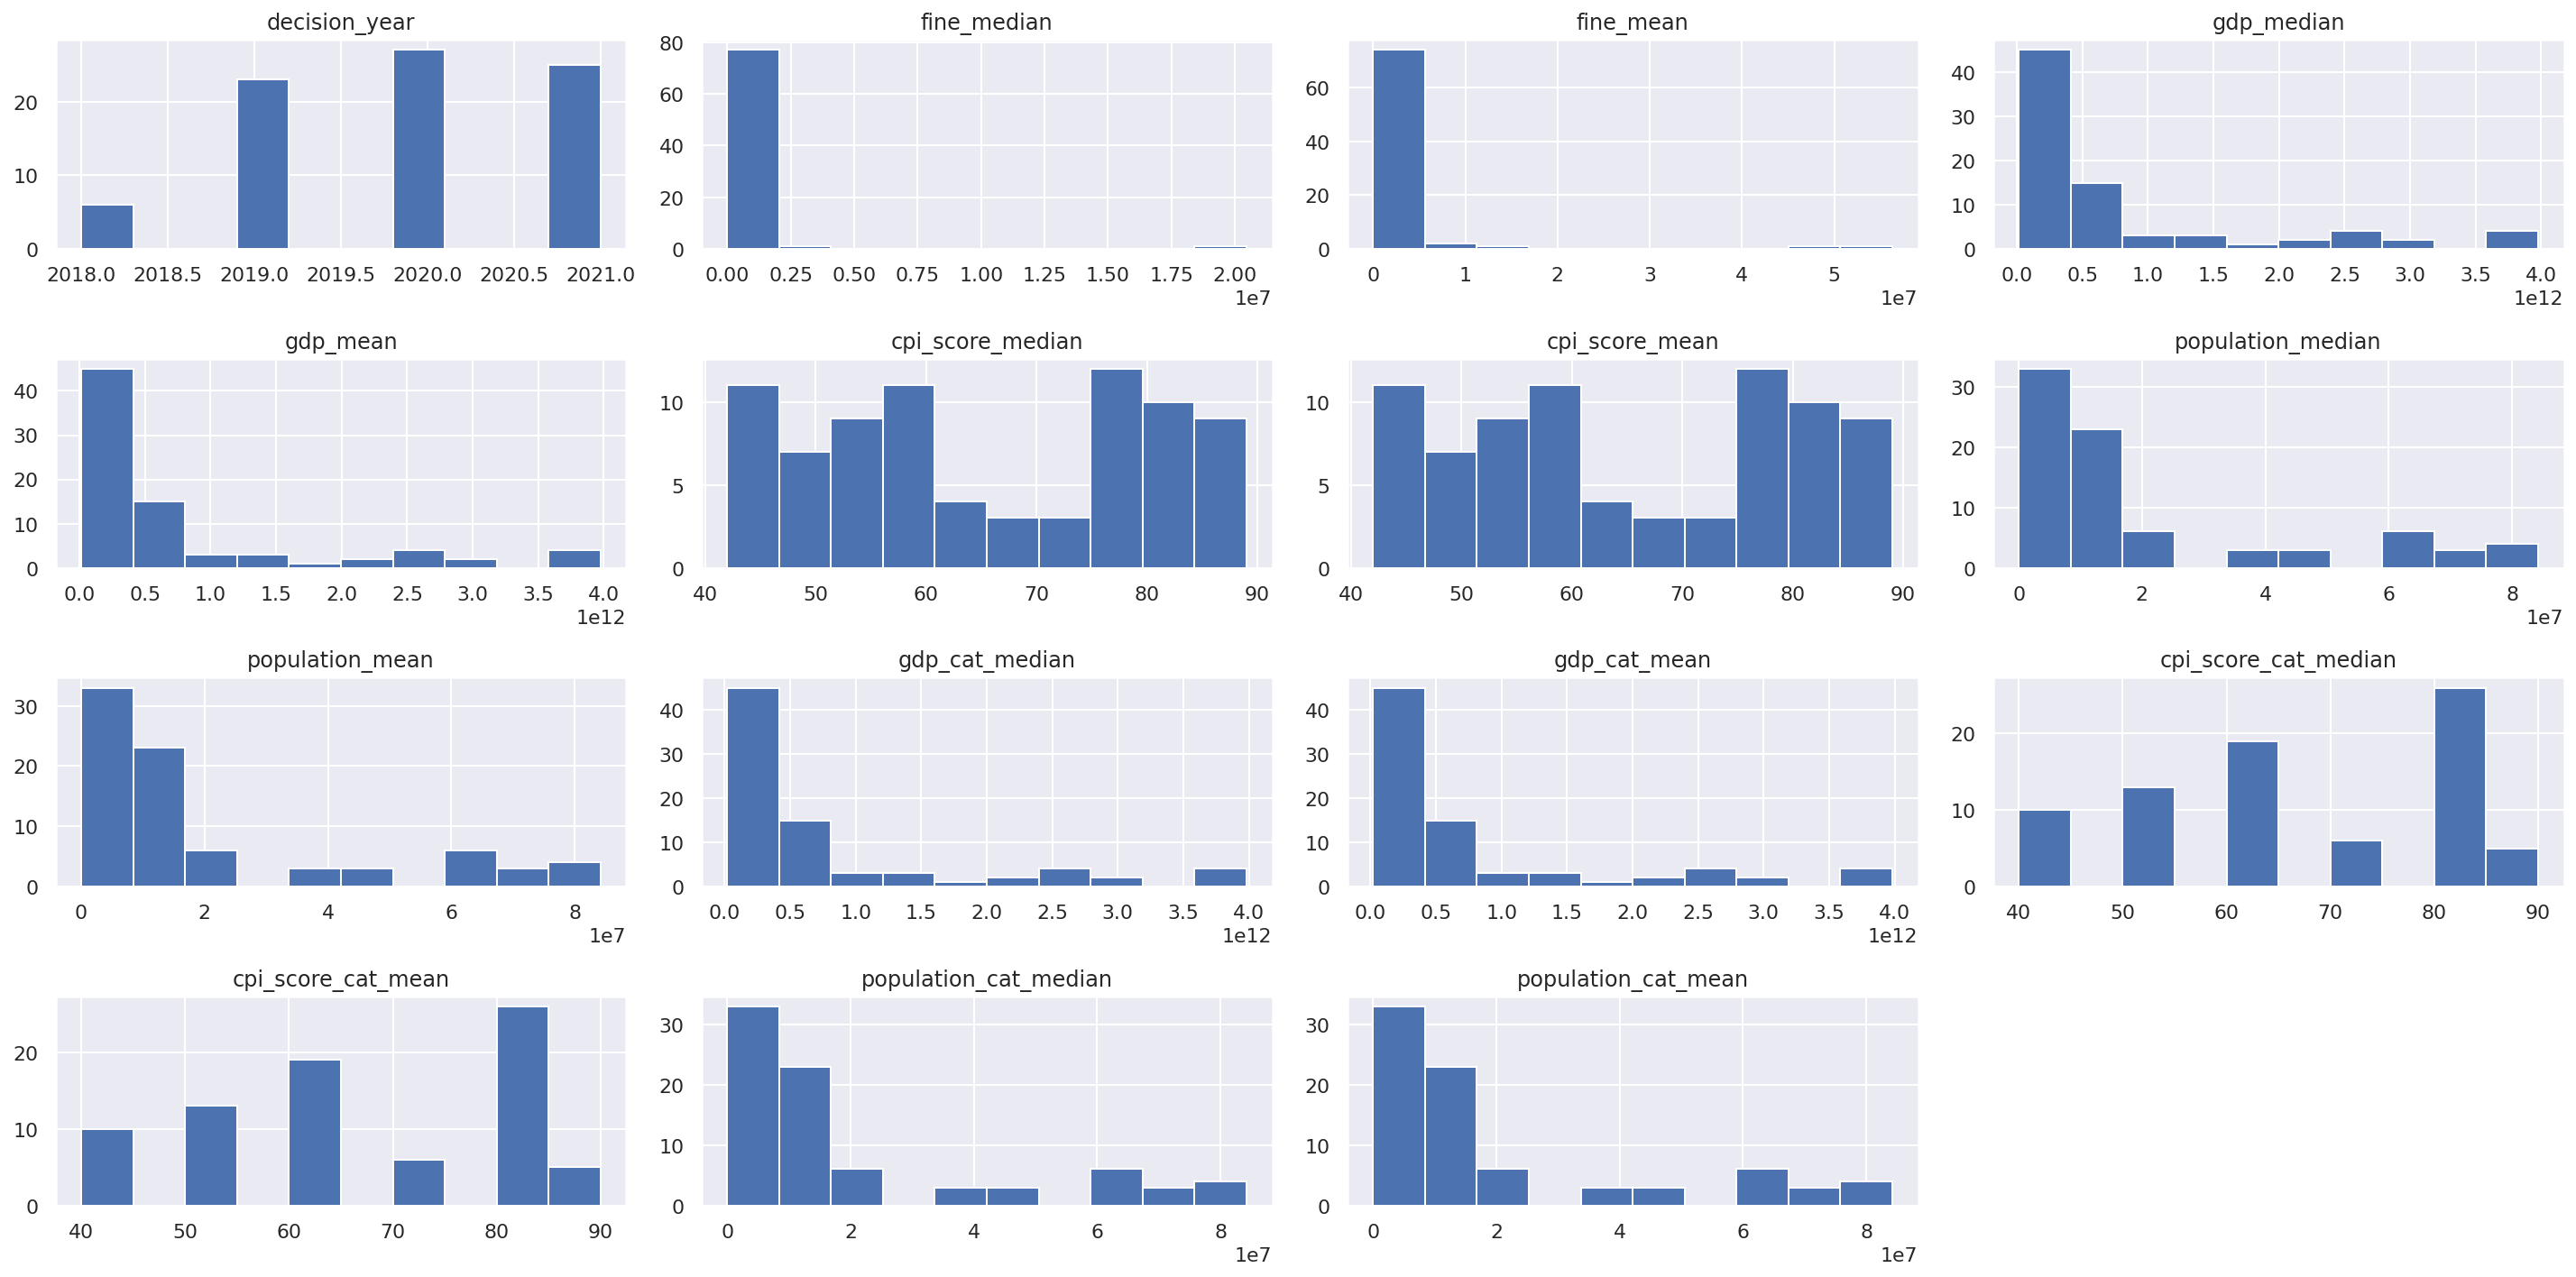

In [46]:
# Check distribution
sns.set(rc={"figure.figsize":(20, 10)})
df_ada_grouped_flatten.hist();

- The aggregated values are not normally distributed. Therefore, **Spearmans'** correlation coefficient will be used for the correlation analysis.
- The aggregated values show outliers, especially for fine (sum), fine (count), fine (mean) and gdp (mean). Those outliers should be reviewed and addressed for an analysis where the outliers have been removed.

#### Check Correlations - "Outliers" Included

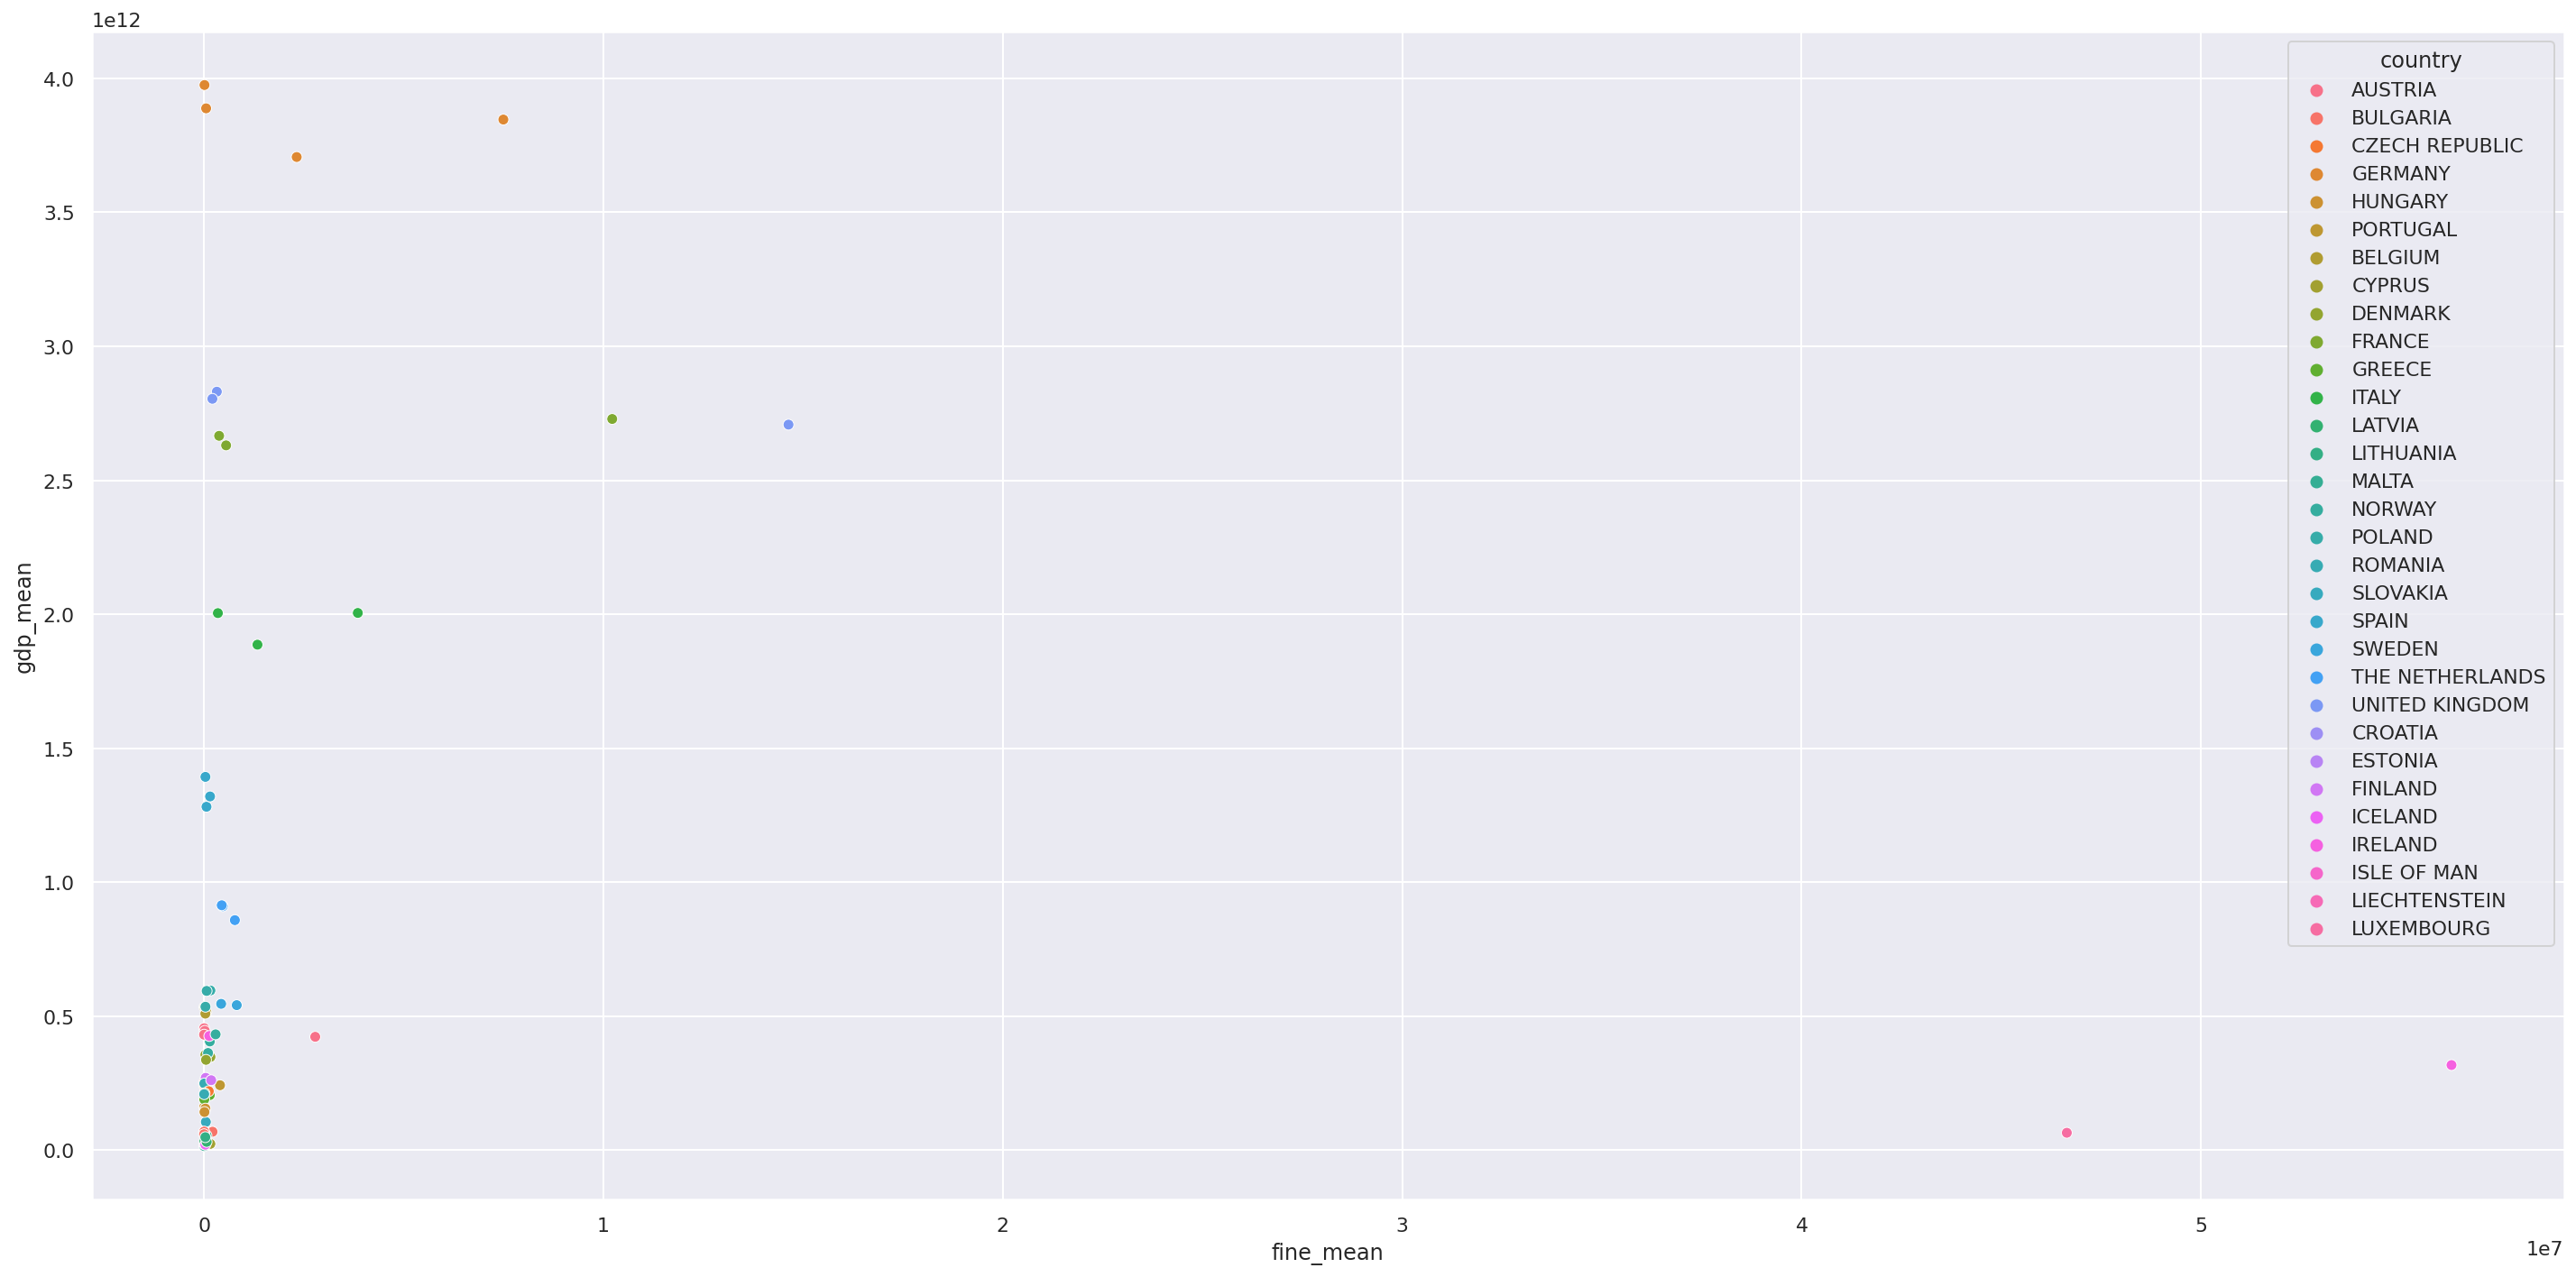

In [47]:
# Checking correlation with "outliers"
sns.set(rc={"figure.figsize":(20, 10)})
sns.scatterplot(data=df_ada_grouped_flatten, x="fine_mean", y="gdp_mean", hue="country",);

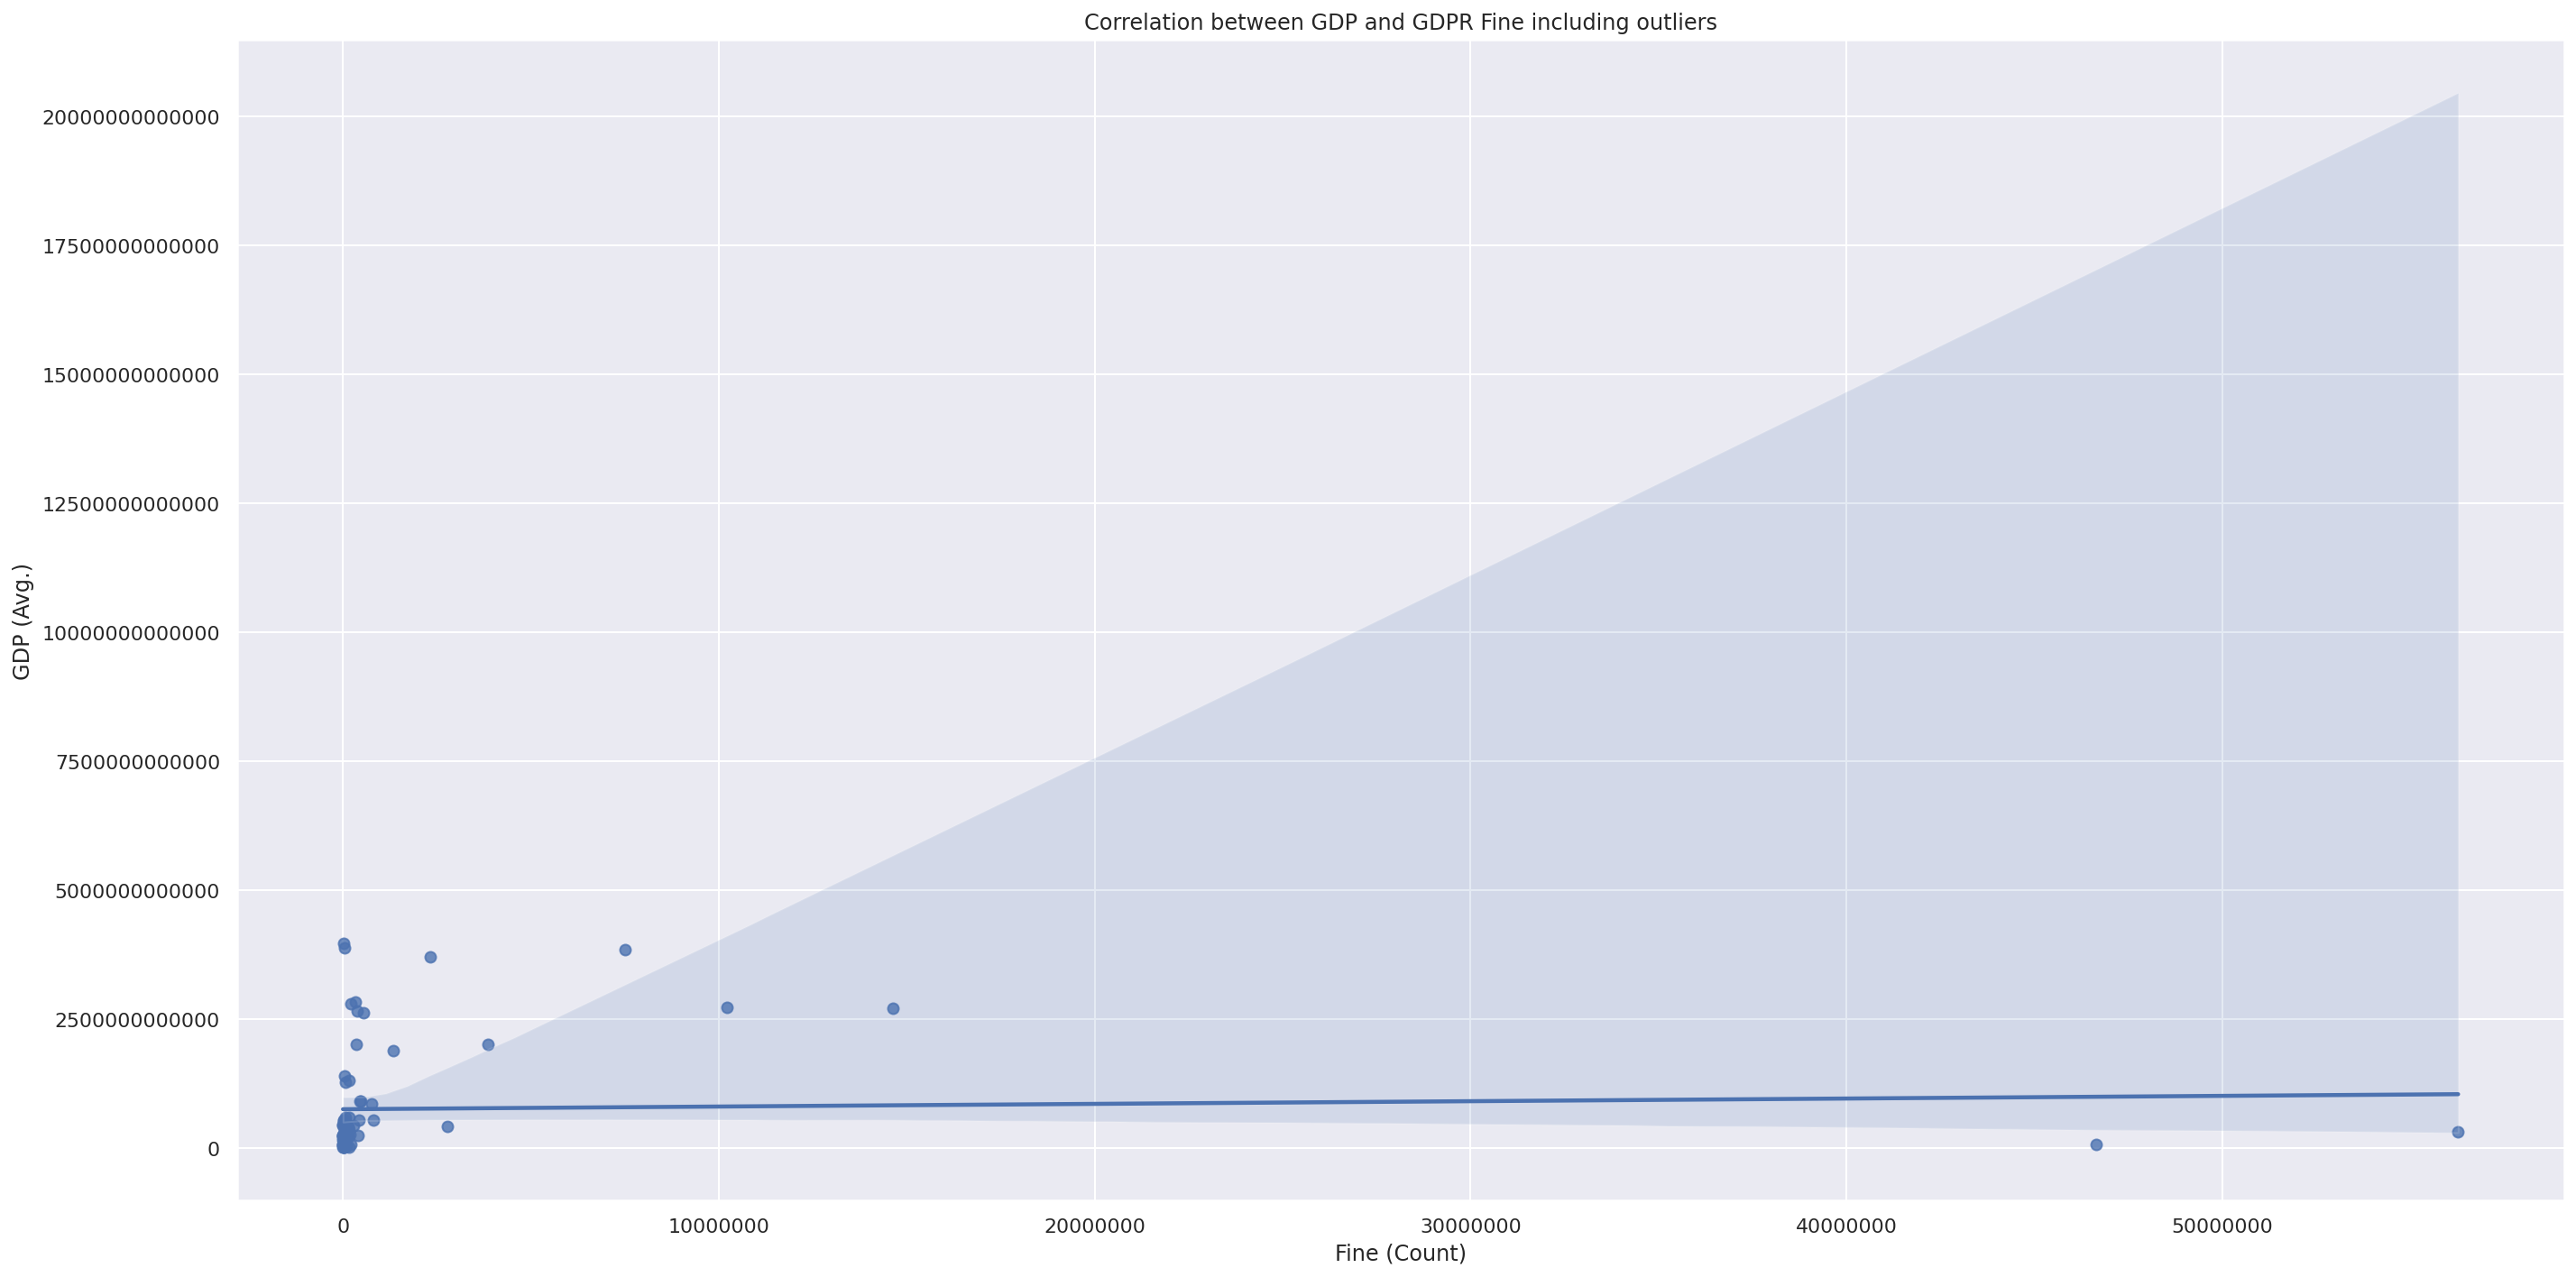

In [48]:
# Checking correlation with "outliers" and trendline
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_ada_grouped_flatten, x="fine_mean", y="gdp_mean");
chart.set(title='Correlation between GDP and GDPR Fine including outliers', xlabel='Fine (Count)', ylabel="GDP (Avg.)");

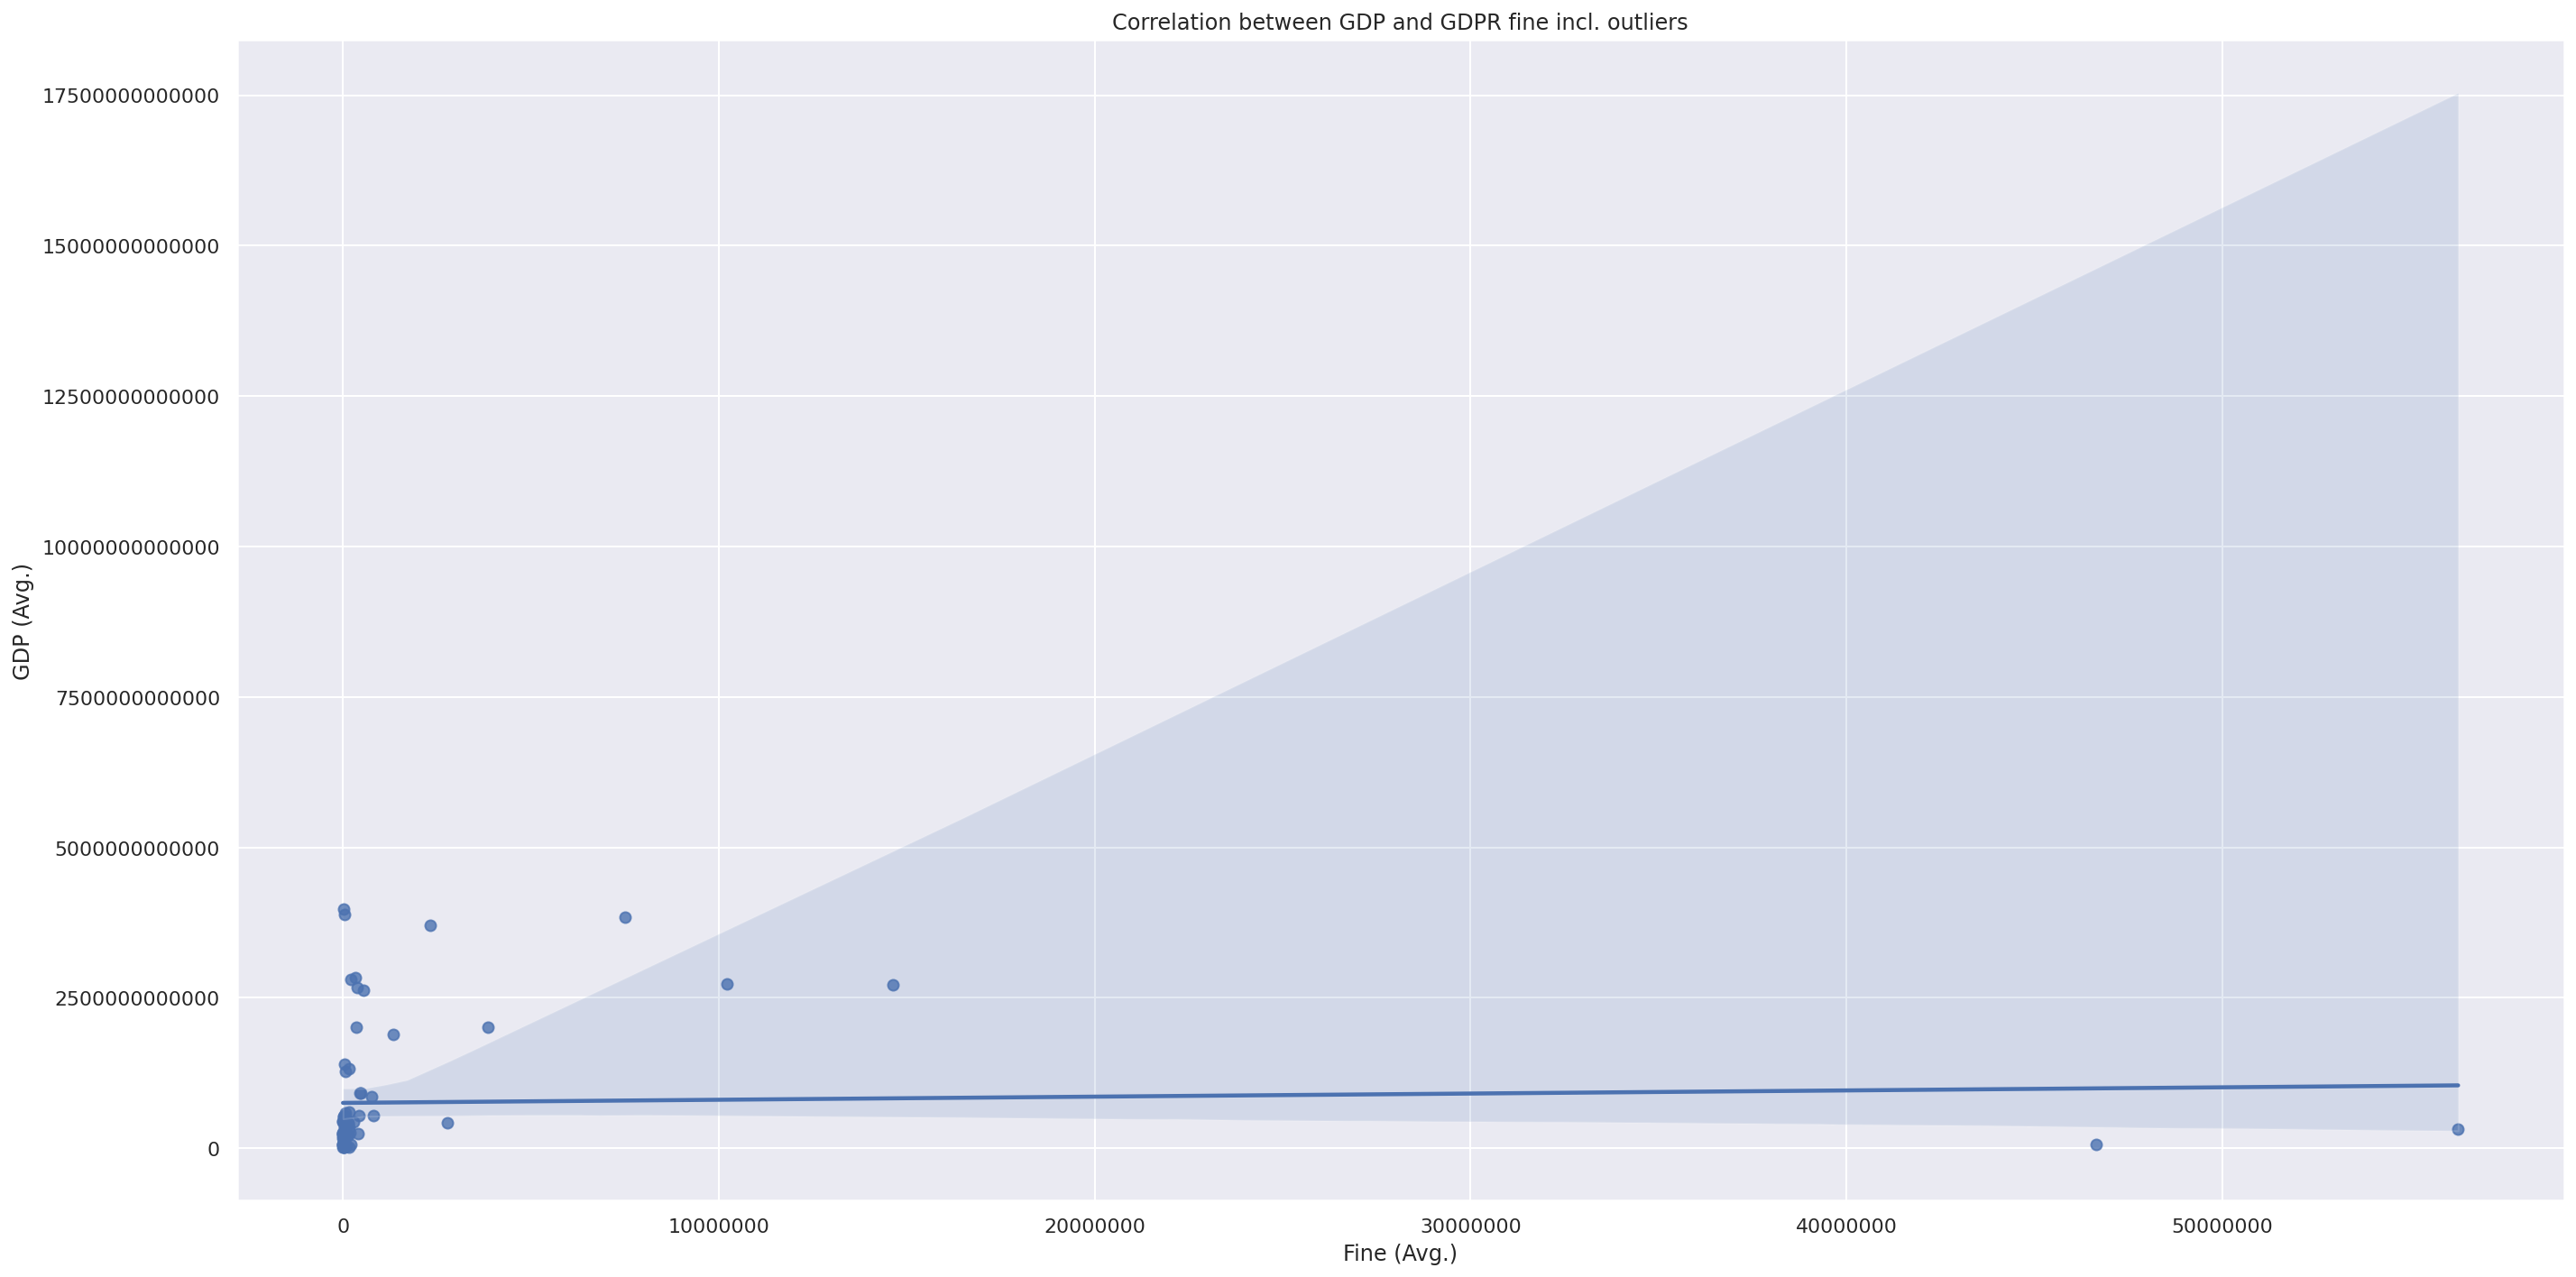

In [49]:
# Checking correlation with "outliers" and trendline
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_ada_grouped_flatten, x="fine_mean", y="gdp_mean");
chart.set(title='Correlation between GDP and GDPR fine incl. outliers', xlabel='Fine (Avg.)', ylabel="GDP (Avg.)");

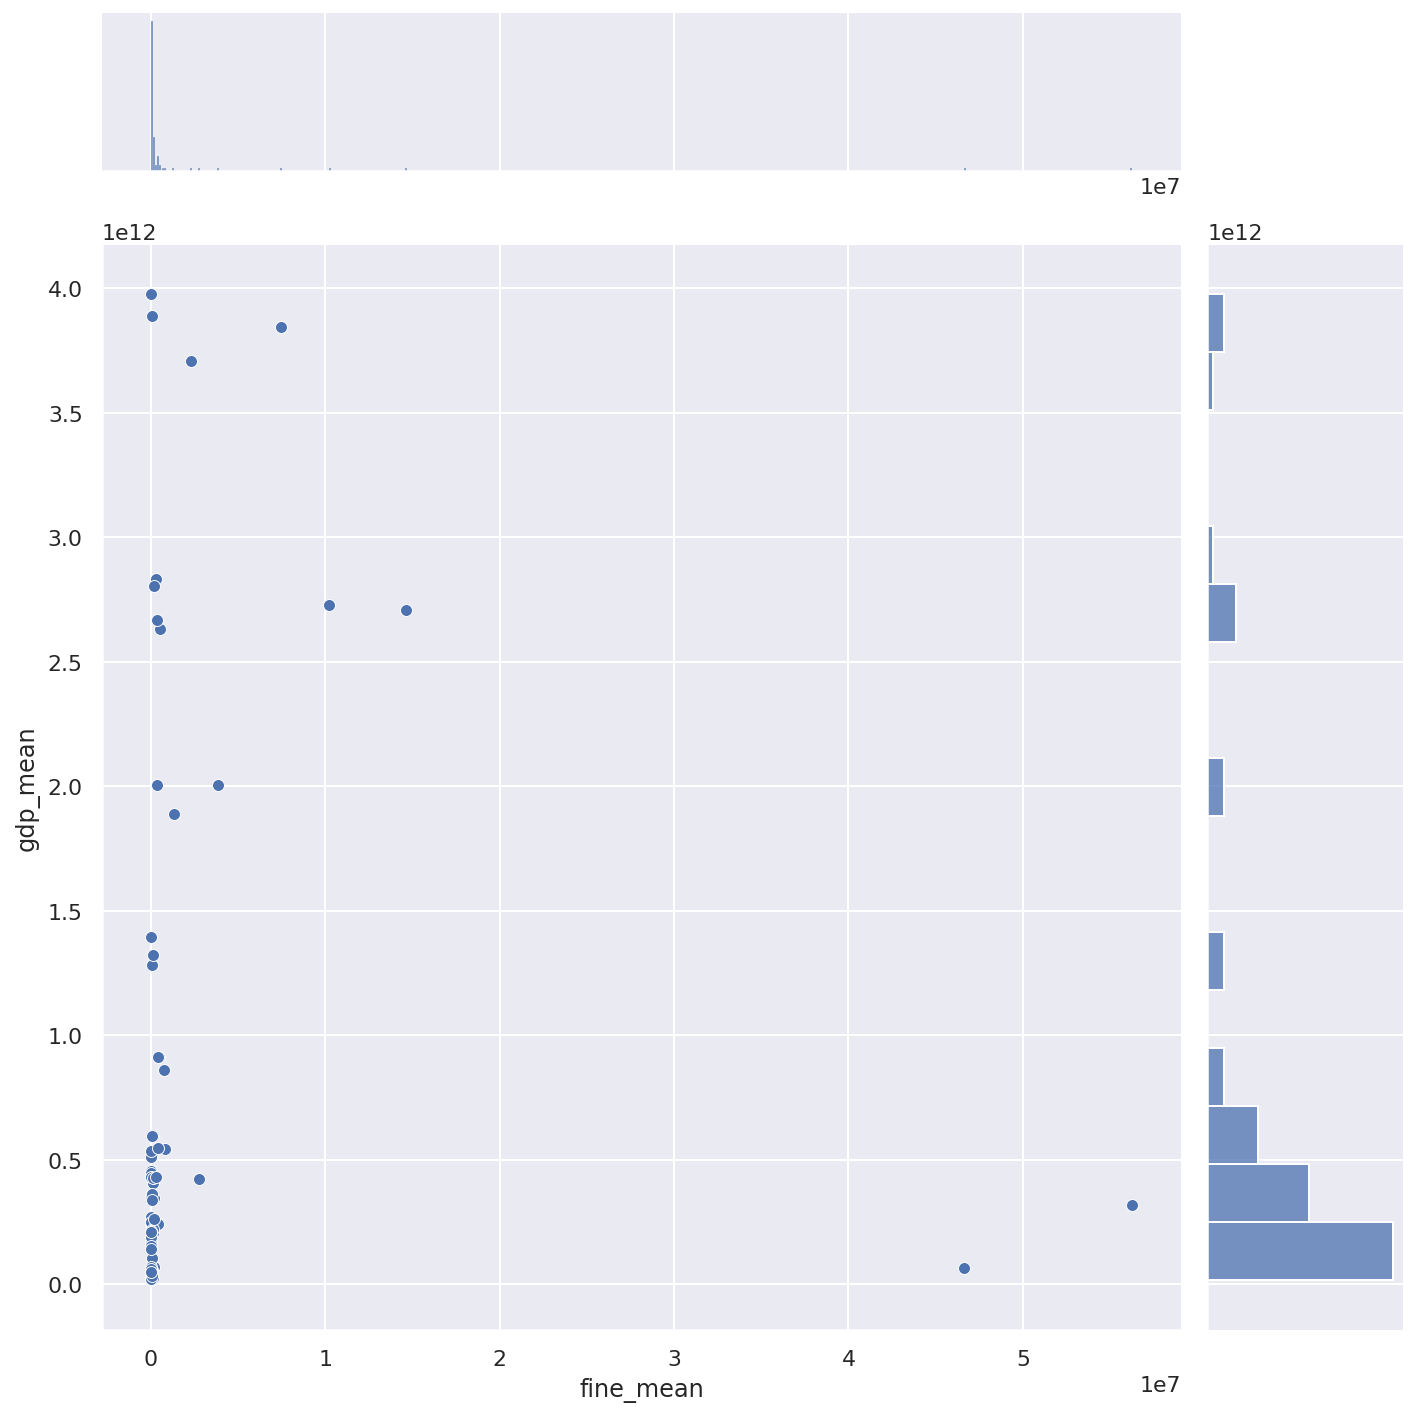

In [50]:
# Checking correlation with "outliers" and distribution (histogram)
sns.jointplot(data=df_ada_grouped_flatten, x="fine_mean", y="gdp_mean", height=10);

In [51]:
# Calculate correlation coefficient with Spearman correlation coefficient, because we
# A) Assume a linear relationship, base from the frist scatter plots
# B) Know that the features are not normally distributed
corr_df = df_ada_grouped_flatten.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

,decision_year,fine_median,fine_mean,gdp_median,gdp_mean,cpi_score_median,cpi_score_mean,population_median,population_mean,gdp_cat_median,gdp_cat_mean,cpi_score_cat_median,cpi_score_cat_mean,population_cat_median,population_cat_mean
decision_year,1.00,0.12,0.25,-0.03,-0.03,0.10,0.10,-0.08,-0.08,-0.03,-0.03,0.09,0.09,-0.08,-0.08
fine_median,0.12,1.00,0.83,0.37,0.37,0.50,0.50,0.17,0.17,0.37,0.37,0.47,0.47,0.16,0.16
fine_mean,0.25,0.83,1.00,0.49,0.49,0.42,0.42,0.31,0.31,0.49,0.49,0.37,0.37,0.31,0.31
gdp_median,-0.03,0.37,0.49,1.00,1.00,0.45,0.45,0.85,0.85,1.00,1.00,0.42,0.42,0.85,0.85
gdp_mean,-0.03,0.37,0.49,1.00,1.00,0.45,0.45,0.85,0.85,1.00,1.00,0.42,0.42,0.85,0.85
cpi_score_median,0.10,0.50,0.42,0.45,0.45,1.00,1.00,0.03,0.03,0.45,0.45,0.97,0.97,0.03,0.03
cpi_score_mean,0.10,0.50,0.42,0.45,0.45,1.00,1.00,0.03,0.03,0.45,0.45,0.97,0.97,0.03,0.03
population_median,-0.08,0.17,0.31,0.85,0.85,0.03,0.03,1.00,1.00,0.85,0.85,0.01,0.01,1.00,1.00
population_mean,-0.08,0.17,0.31,0.85,0.85,0.03,0.03,1.00,1.00,0.85,0.85,0.01,0.01,1.00,1.00
gdp_cat_median,-0.03,0.37,0.49,1.00,1.00,0.45,0.45,0.85,0.85,1.00,1.00,0.42,0.42,0.85,0.85


#### Identify and Address "Outliers"

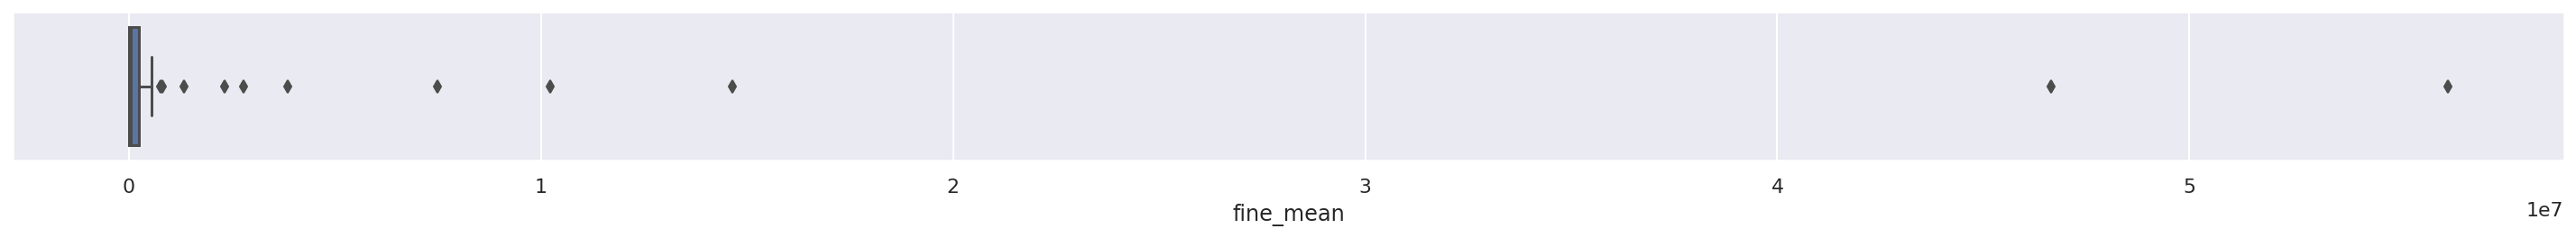

In [52]:
# Identify and remove fine_count "outlier"
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten, x="fine_mean");

In [53]:
df_ada_grouped_flatten[df_ada_grouped_flatten['fine_mean'] > 10000000].round(0).sort_values('fine_mean', ascending=False)

,decision_year,country,fine_median,fine_mean,gdp_median,gdp_mean,cpi_score_median,cpi_score_mean,population_median,population_mean,gdp_cat_median,gdp_cat_mean,cpi_score_cat_median,cpi_score_cat_mean,population_cat_median,population_cat_mean
69,2021,IRELAND,"45,750.0","56,273,225.0","317,444,608,641.0","317,444,608,641.0",73.0,73.0,4996931,4996931,"320,000,000,000.0","320,000,000,000.0",70.0,70.0,5000000,5000000
73,2021,LUXEMBOURG,"10,050.0","46,641,119.0","64,692,749,785.0","64,692,749,785.0",81.0,81.0,638549,638549,"60,000,000,000.0","60,000,000,000.0",80.0,80.0,600000,600000
55,2020,UNITED KINGDOM,"20,450,000.0","14,633,667.0","2,707,743,777,174.0","2,707,743,777,174.0",77.0,77.0,67886011,67886011,"2,710,000,000,000.0","2,710,000,000,000.0",80.0,80.0,67900000,67900000
12,2019,FRANCE,"400,000.0","10,220,000.0","2,728,870,246,706.0","2,728,870,246,706.0",69.0,69.0,65129728,65129728,"2,730,000,000,000.0","2,730,000,000,000.0",70.0,70.0,65100000,65100000


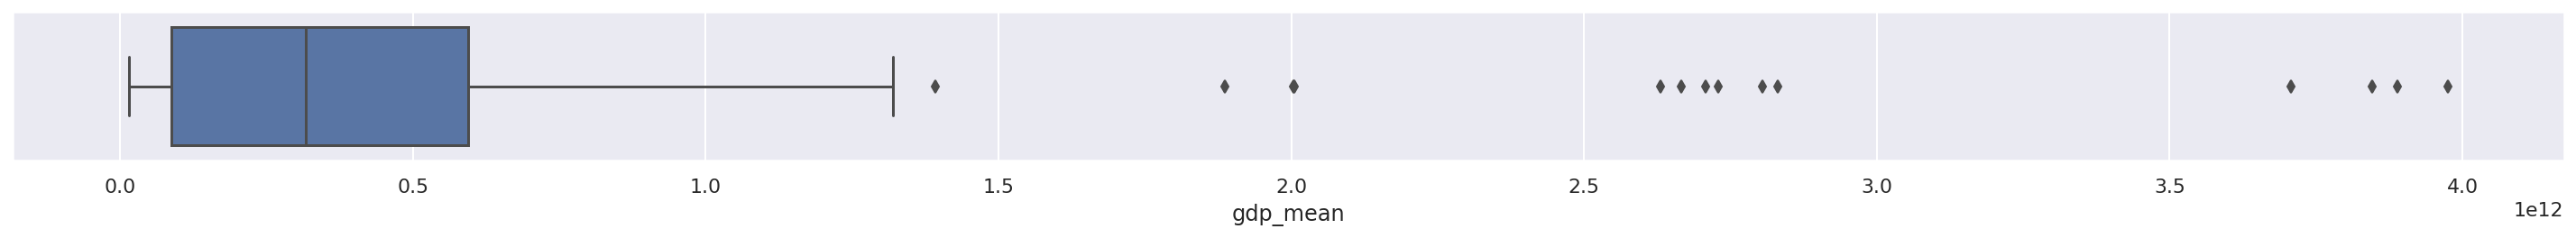

In [54]:
# Identify and remove gdp_mean "outlier"
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten, x="gdp_mean");

In [55]:
df_ada_grouped_flatten[df_ada_grouped_flatten['gdp_mean'] > 1000000000000].round(0).sort_values('gdp_mean', ascending=False)


,decision_year,country,fine_median,fine_mean,gdp_median,gdp_mean,cpi_score_median,cpi_score_mean,population_median,population_mean,gdp_cat_median,gdp_cat_mean,cpi_score_cat_median,cpi_score_cat_mean,population_cat_median,population_cat_mean
3,2018,GERMANY,"12,500.0","11,280.0","3,975,347,237,443.0","3,975,347,237,443.0",80.0,80.0,83124418,83124418,"3,980,000,000,000.0","3,980,000,000,000.0",80.0,80.0,83100000,83100000
13,2019,GERMANY,"15,000.0","52,188.0","3,888,326,788,627.0","3,888,326,788,627.0",80.0,80.0,83517045,83517045,"3,890,000,000,000.0","3,890,000,000,000.0",80.0,80.0,83500000,83500000
39,2020,GERMANY,"900,000.0","7,494,142.0","3,846,413,928,654.0","3,846,413,928,654.0",80.0,80.0,83783942,83783942,"3,850,000,000,000.0","3,850,000,000,000.0",80.0,80.0,83800000,83800000
65,2021,GERMANY,"300,000.0","2,320,000.0","3,706,618,087,819.0","3,706,618,087,819.0",80.0,80.0,84189092,84189092,"3,710,000,000,000.0","3,710,000,000,000.0",80.0,80.0,84200000,84200000
28,2019,UNITED KINGDOM,"320,000.0","320,000.0","2,830,813,507,747.0","2,830,813,507,747.0",77.0,77.0,67530172,67530172,"2,830,000,000,000.0","2,830,000,000,000.0",80.0,80.0,67500000,67500000
80,2021,UNITED KINGDOM,"29,000.0","208,600.0","2,804,131,075,095.0","2,804,131,075,095.0",78.0,78.0,68298609,68298609,"2,800,000,000,000.0","2,800,000,000,000.0",80.0,80.0,68300000,68300000
12,2019,FRANCE,"400,000.0","10,220,000.0","2,728,870,246,706.0","2,728,870,246,706.0",69.0,69.0,65129728,65129728,"2,730,000,000,000.0","2,730,000,000,000.0",70.0,70.0,65100000,65100000
55,2020,UNITED KINGDOM,"20,450,000.0","14,633,667.0","2,707,743,777,174.0","2,707,743,777,174.0",77.0,77.0,67886011,67886011,"2,710,000,000,000.0","2,710,000,000,000.0",80.0,80.0,67900000,67900000
64,2021,FRANCE,"240,000.0","377,800.0","2,666,009,452,625.0","2,666,009,452,625.0",70.0,70.0,65438828,65438828,"2,670,000,000,000.0","2,670,000,000,000.0",70.0,70.0,65400000,65400000
38,2020,FRANCE,"128,650.0","552,717.0","2,630,317,731,455.0","2,630,317,731,455.0",69.0,69.0,65273511,65273511,"2,630,000,000,000.0","2,630,000,000,000.0",70.0,70.0,65300000,65300000


In [56]:
# Remove fine_count "outliers"
df_ada_grouped_flatten_adjusted = df_ada_grouped_flatten[df_ada_grouped_flatten['fine_count'] < 50]
#df_ada_grouped_flatten_adjusted = df_ada_grouped_flatten_adjusted[df_ada_grouped_flatten_adjusted['gdp_mean'] < 1000000000000]

KeyError: ignored

In [ ]:
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten_adjusted, x="fine_count");

#### Check Correlation "Outliers" Removed

In [ ]:
plt.figure(figsize=(20, 10))
chart = sns.regplot(data=df_ada_grouped_flatten_adjusted, x="fine_count", y="gdp_mean");
chart.set(title='Correlation between GDP and GDPR Fine corrected by outliers', xlabel='Fine (Count)', ylabel="GDP (Avg.)");

In [ ]:
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_ada_grouped_flatten_adjusted.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

#### **Conclusion**

...

### **A higher CPI could lead to more reported cases**
because the public sector is potentially less influenced (corrupted) by the companies


#### Prepare Dataframe

**What Is the Corruption Perceptions Index (CPI)?**
The term Corruption Perceptions Index (CPI) refers to an index that scores countries on the perceived levels of government corruption by country. Scores range from zero to 100, with **zero indicating high levels of corruption and 100 indicating low levels**. The CPI is published annually by Transparency International, an organization that seeks to stop bribery, fraud, and other forms of public sector corruption.

https://www.investopedia.com/terms/c/corruption-perception-index.asp

In [ ]:
df_ada_grouped = df.groupby(['country','iso3'])['fine','gdp','cpi_score','population'].agg({'fine':['sum','count','mean'],'gdp':'mean','cpi_score':'mean','population':'mean'}).reset_index()
#df_ada_grouped

In [ ]:
# flatten grouped dataframe
df_ada_grouped_flatten = df_ada_grouped.copy()
df_ada_grouped_flatten.columns = ['_'.join(i).rstrip('_') for i in df_ada_grouped_flatten.columns.values]
df_ada_grouped_flatten

#### Check Distributions - "Outliers" Included

In [ ]:
# Check distribution
sns.set(rc={"figure.figsize":(20, 10)})
df_ada_grouped_flatten.hist();

#### Check Correlations - "Outliers" Included

In [ ]:
# Checking correlation with "outliers"
sns.set(rc={"figure.figsize":(20, 10)})
sns.scatterplot(data=df_ada_grouped_flatten, x="fine_count", y="cpi_score_mean", hue="country",);

In [ ]:
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_ada_grouped_flatten, x="fine_count", y="cpi_score_mean");
chart.set(title='Correlation between CPI score and GDPR fine incl. outliers', xlabel='Fine (Count)', ylabel="CPI Score (Avg.)");

In [ ]:
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_ada_grouped_flatten, x="fine_mean", y="cpi_score_mean");
chart.set(title='Correlation between CPI score and GDPR fine incl. outliers', xlabel='Fine (Avg.)', ylabel="CPI Score (Avg.)");

In [ ]:
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_ada_grouped_flatten.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

#### Identify and Address "Outliers"

In [ ]:
# Identify and remove fine_count "outlier"
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten, x="fine_count");

In [ ]:
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten, x="cpi_score_mean");

In [ ]:
# Remove fine_count "outliers"
df_ada_grouped_flatten_adjusted = df_ada_grouped_flatten[df_ada_grouped_flatten['fine_count'] < 50]

In [ ]:
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten_adjusted, x="fine_count");

#### Check Correlations - "Outliers" Removed


In [ ]:
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_ada_grouped_flatten_adjusted, x="fine_count", y="cpi_score_mean");
chart.set(title='Correlation between CPI Score and amount of GDPR Fines corrected by outliers', xlabel='Fine (Count)', ylabel="CPI Score (Avg.)");

In [ ]:
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_ada_grouped_flatten_adjusted.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

#### **Conclusion**

### **A higher population could lead to more reported cases**
because more data subjects could execute their rights

#### Prepare Dataframe

In [ ]:
df_ada_grouped = (
    df.groupby(["country", "iso3"])["fine", "gdp", "cpi_score", "population"]
    .agg(
        {
            "fine": ["sum", "count", "mean"],
            "gdp": ["mean"],
            "cpi_score": ["mean"],
            "population": ["mean"],
        }
    )
    .reset_index()
)
# df_ada_grouped



In [ ]:
# flatten grouped dataframe
df_ada_grouped_flatten = df_ada_grouped.copy()
df_ada_grouped_flatten.columns = [
    "_".join(i).rstrip("_") for i in df_ada_grouped_flatten.columns.values
]
df_ada_grouped_flatten.round(0)


#### Check Distributions - "Outliers" Included

In [ ]:
# Check distribution
sns.set(rc={"figure.figsize":(20, 10)})
df_ada_grouped_flatten.hist();

#### Check Correlation - "Outliers" Included 

In [ ]:
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_ada_grouped_flatten, x="fine_count", y="population_mean");
chart.set(title='Correlation between population and GDPR fine incl. outliers', xlabel='Fine (Count)', ylabel="Population (Avg.)");

In [ ]:
chart = sns.jointplot(data=df_ada_grouped_flatten, x="fine_count", y="population_mean", height=10);

In [ ]:
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_ada_grouped_flatten.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

#### Identify and Address "Outliers"

In [ ]:
# Identify and remove fine_count "outlier"
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten, x="fine_count");

In [ ]:
# Remove "outliers"
df_ada_grouped_flatten_adjusted = df_ada_grouped_flatten[df_ada_grouped_flatten['fine_count'] < 50]

In [ ]:
sns.set(rc={"figure.figsize":(20, 2)})
sns.boxplot(data=df_ada_grouped_flatten_adjusted, x="fine_count");

In [ ]:
chart = sns.jointplot(data=df_ada_grouped_flatten_adjusted, x="fine_count", y="population_mean", height=10);

#### Check Correlation - "Outliers" Removed

In [ ]:
plt.figure(figsize=(20, 10))
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

chart = sns.regplot(data=df_ada_grouped_flatten_adjusted, x="fine_count", y="population_mean");
chart.set(title='Correlation between population (mean) and amount of GDPR fines (count) corrected by outliers', xlabel='Fine (Count)', ylabel="Population (Avg.)");

In [ ]:
# Pearson's r cannot be used, because the varibales are not normally distributed
corr_df = df_ada_grouped_flatten_adjusted.corr(method='spearman')
corr_df.style.background_gradient(cmap='coolwarm').set_precision(2)

#### **Conclusion**

...

## Additional Questions Identified During Analysis

### Focus on the Sector "Health Care"

In [57]:
df_split.head()

,etid,country,fine,controller_processor,article,violation_type,sector,summary,decision_date_imputed,decision_year,fine_cat,fine_cat2,mapping_key,country_label,violation_type_label,sector_label,gdp,gdp_cat,iso3,cpi_score,cpi_score_cat,population,population_cat,gdpr_article_short,gdpr_article,gdpr_article_short_label
0,ETid-986,GREECE,"30,000.0",Info Communication Services,Art. 13 GDPR,Insufficient fulfilment of informati...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"30,000.0",6.0,GREECE-2021,11,4,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000,Art. 13,True,1
0,ETid-986,GREECE,"30,000.0",Info Communication Services,Art. 14 GDPR,Insufficient fulfilment of informati...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"30,000.0",6.0,GREECE-2021,11,4,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000,Art. 14,True,2
1,ETid-985,GREECE,"25,000.0",Plus Real Advertisement,Art. 13 GDPR,Insufficient fulfilment of informati...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"25,000.0",6.0,GREECE-2021,11,4,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000,Art. 13,True,1
1,ETid-985,GREECE,"25,000.0",Plus Real Advertisement,Art. 14 GDPR,Insufficient fulfilment of informati...,Industry and Commerce,The Hellenic DPA has imposed a fine ...,No,2021,"25,000.0",6.0,GREECE-2021,11,4,5,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000,Art. 14,True,2
2,ETid-957,GREECE,"30,000.0",One Way Private Company,Art. 28 (3) c) GDPR,Insufficient technical and organisat...,"Media, Telecoms and Broadcasting",The Hellenic DPA has imposed a fine ...,No,2021,"30,000.0",6.0,GREECE-2021,11,7,6,"212,266,363,527.0","210,000,000,000.0",GRC,44.0,40.0,10376349,10400000,Art. 28,True,14


In [58]:
# Select Health Care sector
df_hc = df_split.loc[df_split['sector'] == 'Health Care']

# Group data over columns etid, country, violation_type and fine to remove any duplicates
df_hc_summary = df_hc.drop_duplicates(subset=['etid', 'country', 'violation_type', 'fine'])

# Calculate the total fine ammount per violation type
#df_hc_summary = df_hc_summary.groupby(['violation_type'])['fine'].agg('sum').reset_index(name ='fine').sort_values(by='fine', ascending=False)
df_hc_summary = df_hc_summary.groupby('violation_type').agg(Fine=('fine', 'sum'), Count_Fine=('etid', 'count'), Fine_Max=('fine', 'max'), Fine_Mean=('fine', 'mean')).sort_values(by='Fine', ascending=False).reset_index()

# Calculate percentage of occurance of the fine
fines_count = df_hc_summary['Count_Fine'].sum()
df_hc_summary['Percentage_Fine_Occ'] = df_hc_summary['Count_Fine'] / fines_count

# Calculate risk score by multipling the percentage (frequency) of occurance with the average fine amount
df_hc_summary['Risk_Score'] = df_hc_summary['Percentage_Fine_Occ'] * df_hc_summary['Fine_Mean']

# Reformat the style of the columns
#df_hc_summary = df_hc_summary.style.format({'Fine': '{:.2f}','Fine_Max': '{:.2f}','Fine_Mean': '{:.2f}','Risk_Score': '{:.2f}','Percentage_Fine_Occ': '{:.1%}'}) # Display as percentage

df_hc_summary

,violation_type,Fine,Count_Fine,Fine_Max,Fine_Mean,Percentage_Fine_Occ,Risk_Score
0,Insufficient technical and organisat...,"9,375,887.0",32,"2,900,000.0","292,996.46875",0.4,"117,198.58750000001"
1,Non-compliance with general data pro...,"2,440,700.0",15,"1,200,000.0","162,713.33333333334",0.1875,"30,508.75"
2,Insufficient legal basis for data pr...,"484,035.0",17,"100,000.0","28,472.647058823528",0.2125,"6,050.437499999999"
3,Insufficient fulfilment of informati...,"152,400.0",6,"50,000.0","30,480.0",0.075,"2,286.0"
4,Insufficient fulfilment of data subj...,"27,000.0",5,"8,000.0","5,400.0",0.0625,337.5
5,Insufficient fulfilment of data brea...,"26,400.0",2,"19,000.0","13,200.0",0.025,330.0
6,Insufficient cooperation with superv...,"4,511.0",3,"2,000.0","1,503.6666666666667",0.0375,56.3875


In [59]:
# Analyse all sectors
df_all_sectors = df_split

# Group data over columns etid, country, violation_type and fine to remove any duplicates
df_summary = df_all_sectors.drop_duplicates(subset=['etid', 'country', 'violation_type', 'fine'])

# Calculate the total fine ammount per violation type
#df_hc_summary = df_hc_summary.groupby(['violation_type'])['fine'].agg('sum').reset_index(name ='fine').sort_values(by='fine', ascending=False)
df_summary = df_summary.groupby('violation_type').agg(Fine=('fine', 'sum'), Count_Fine=('etid', 'count'), Fine_Max=('fine', 'max'), Fine_Mean=('fine', 'mean')).sort_values(by='Fine', ascending=False).reset_index()

# Calculate percentage of occurance of the fine
fines_count = df_summary['Count_Fine'].sum()
df_summary['Percentage_Fine_Occ'] = df_summary['Count_Fine'] / fines_count

# Calculate risk score by multipling the percentage (frequency) of occurance with the average fine amount
df_summary['Risk_Score'] = df_summary['Percentage_Fine_Occ'] * df_summary['Fine_Mean']

# Reformat the style of the columns
#df_summary = df_summary.style.format({'Fine': '{:.2f}','Fine_Max': '{:.2f}','Fine_Mean': '{:.2f}','Risk_Score': '{:.2f}','Percentage_Fine_Occ': '{:.1%}'}) # Display as percentage

df_summary

,violation_type,Fine,Count_Fine,Fine_Max,Fine_Mean,Percentage_Fine_Occ,Risk_Score
0,Non-compliance with general data pro...,"784,702,244.0",197,"746,000,000.0","4,065,814.7357512955",0.20143149284253578,"818,983.1318435636"
1,Insufficient fulfilment of informati...,"235,031,595.0",82,"225,000,000.0","2,975,083.481012658",0.08384458077709611,"249,444.6272423701"
2,Insufficient legal basis for data pr...,"192,517,188.0",337,"50,000,000.0","590,543.5214723926",0.3445807770961145,"203,489.94553803303"
3,Insufficient technical and organisat...,"69,947,969.0",193,"22,046,000.0","372,063.66489361704",0.19734151329243355,"73,423.60667123526"
4,Insufficient fulfilment of data subj...,"16,801,325.0",90,"8,150,000.0","193,118.67816091955",0.09202453987730061,"17,771.657499471123"
5,Unknown,"14,703,900.0",4,"9,500,000.0","3,675,975.0",0.00408997955010225,"15,034.662576687118"
6,Insufficient fulfilment of data brea...,"1,362,091.0",21,"475,000.0","64,861.47619047619",0.02147239263803681,"1,392.7310838445808"
7,Insufficient data processing agreement,"993,580.0",5,"900,000.0","198,716.0",0.005112474437627812,"1,015.9304703476483"
8,Insufficient involvement of data pro...,"275,600.0",11,"51,000.0","25,054.545454545456",0.011247443762781187,281.799591002045
9,Insufficient cooperation with superv...,"224,929.0",38,"40,000.0","5,919.184210526316",0.03885480572597137,229.98875255623724


In [95]:
import altair as alt
from vega_datasets import data

alt.Chart(df_hc_summary).mark_circle(size=500).encode(
    x=alt.X('Percentage_Fine_Occ', axis=alt.Axis(format='%'), scale=alt.Scale(domain=[0, 0.50]), title='Probability of fine occurance'),
    y=alt.X('Fine_Mean', title='Fine mean amount [Euro]', scale=alt.Scale(type='log')),
    color='violation_type',
    size='Count_Fine'
).properties(
    width=500,
    height=500
).configure_legend(labelLimit= 0)

alt.Chart(...)

In [94]:
import altair as alt
from vega_datasets import data

alt.Chart(df_summary).mark_circle(size=500).encode(
    x=alt.X('Percentage_Fine_Occ', axis=alt.Axis(format='%'), scale=alt.Scale(domain=[0, 0.50]), title='Percentage of fine occurance'),
    y=alt.X('Fine_Mean', title='Fine mean amount [Euro]', scale=alt.Scale(type='log')),
    color='violation_type',
    size='Count_Fine'
).properties(
    width=500,
    height=500
).configure_legend(labelLimit= 0)

alt.Chart(...)

In [62]:
import plotly.express as px
fig = px.scatter(df_summary, x="Percentage_Fine_Occ", y="Fine_Mean", color="violation_type", symbol="violation_type", size="Count_Fine")
fig.show()

# Watermark

In [ ]:
%watermark

In [ ]:
%watermark --iversions

-----
